In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.signal
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.interpolate import interp1d
from pydub import AudioSegment
import pywt
import optimalK
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.utils import shuffle
from collections import Counter
from copy import deepcopy
import itertools
import os
import pickle
import random
import cProfile
from collections import defaultdict

In [2]:
folder_path = '../audios/lab_audios/first_batch/'
with open(f'{folder_path}all_segments.pkl', 'rb') as file:
    all_segments = pickle.load(file)

In [3]:
def band_stop_filter(y, sr, highcut, order=4):
    nyquist = 0.5 * sr
    normal_cutoff = highcut / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = scipy.signal.filtfilt(b, a, y)
    return y_filtered

def process_individual_snippets_with_fft(all_segments, file_names, sr=None):
    processed_segments_fft = []
    
    file_idx = 0
    while file_idx < len(file_names):
        file_name = file_names[file_idx]
        print(f"Loading file: {file_name}")
        
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            file_idx += 1
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]

        for idx, segment in enumerate(file_segments):
            start_time = segment['start_time']
            end_time = segment['end_time']
            
            print(f"Processing snippet {idx + 1}/{len(file_segments)}: {start_time:.2f}s to {end_time:.2f}s")

            start_idx = int(start_time * original_sr)
            end_idx = int(end_time * original_sr)
            
            snippet = y[start_idx:end_idx]
            
            fft_result = np.fft.fft(snippet)
            fft_magnitude = np.abs(fft_result)
            fft_frequencies = np.fft.fftfreq(len(snippet), d=1/original_sr)  # Get frequencies
            
            processed_segments_fft.append({
                'file_name': file_name,
                'start_time': start_time,
                'end_time': end_time,
                'fft_magnitude': fft_magnitude,
                'fft_frequencies': fft_frequencies
            })

        file_idx += 1

    return processed_segments_fft


In [4]:
folder_path = '../audios/lab_audios/first_batch/'
file_names = [f'{folder_path}recording_20240927_204919-{i:02d}.wav' for i in range(1, 17)]
# processed_segments_fft = process_individual_snippets_with_fft(all_segments, file_names)

# # Save the results if needed
# with open(f'{folder_path}processed_segments_fft.pkl', 'wb') as file:
#     pickle.dump(processed_segments_fft, file)

# print("FFT processing complete. Results saved.")


with open(f'{folder_path}processed_segments_fft.pkl', 'rb') as file:
    processed_segments_fft = pickle.load(file)

In [5]:
for segment in processed_segments_fft:
    # Get the fft_frequencies and fft_magnitude fields
    fft_frequencies = segment['fft_frequencies']
    fft_magnitude = segment['fft_magnitude']
    
    # Filter for non-negative frequencies
    non_negative_indices = fft_frequencies >= 0
    segment['fft_frequencies'] = fft_frequencies[non_negative_indices]
    segment['fft_magnitude'] = fft_magnitude[non_negative_indices]

print("Negative frequencies have been removed from all segments.")

Negative frequencies have been removed from all segments.


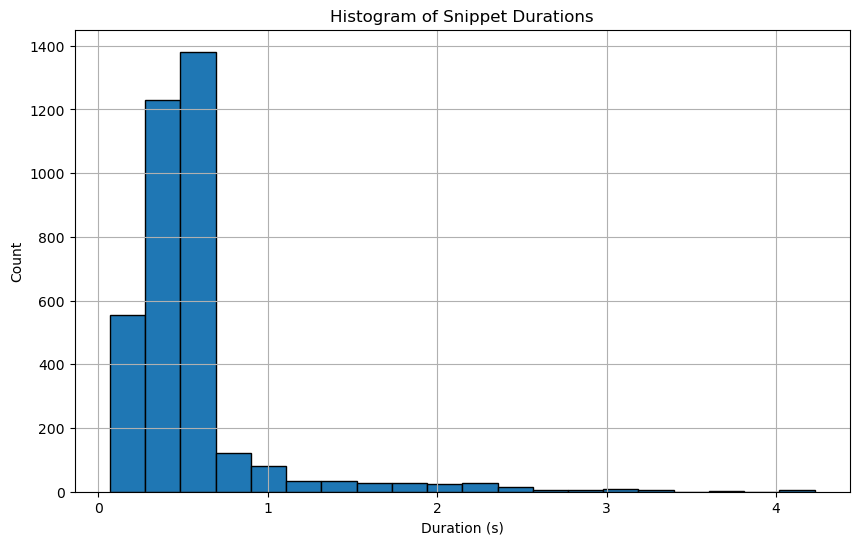

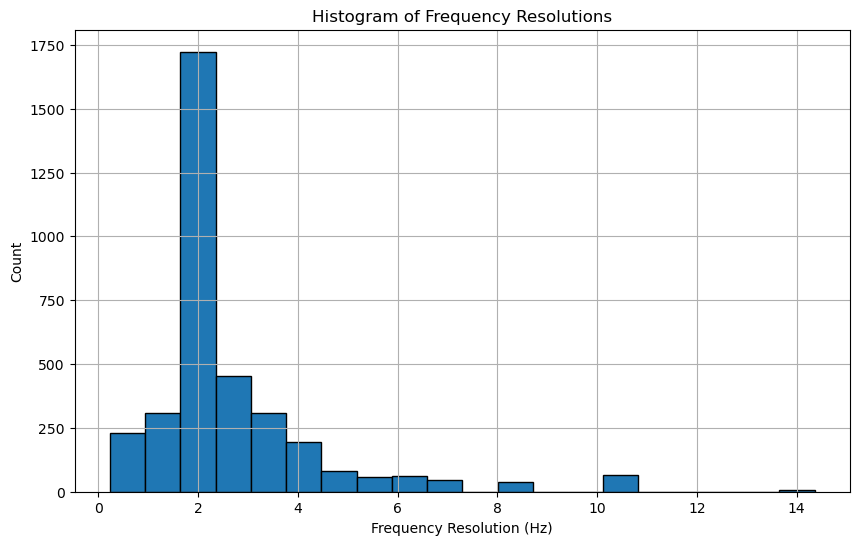

In [6]:
# investigate resolution inconsistencies
durations = [segment['end_time'] - segment['start_time'] for segment in processed_segments_fft]
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, edgecolor='black')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.title('Histogram of Snippet Durations')
plt.grid(True)
plt.show()

frequency_resolutions = []
for segment in processed_segments_fft:
    fft_frequencies = segment['fft_frequencies']
    positive_frequencies = fft_frequencies[fft_frequencies >= 0]  # Only positive frequencies
    resolution = np.min(np.diff(positive_frequencies))
    frequency_resolutions.append(resolution)

plt.figure(figsize=(10, 6))
plt.hist(frequency_resolutions, bins=20, edgecolor='black')
plt.xlabel('Frequency Resolution (Hz)')
plt.ylabel('Count')
plt.title('Histogram of Frequency Resolutions')
plt.grid(True)
plt.show()

In [7]:
print(processed_segments_fft[0]['fft_magnitude'][0])

0.011074838859822193


In [9]:
def verify_frequency_resolution(processed_segments_fft):
    frequency_resolutions = []
    for idx, segment in enumerate(processed_segments_fft):
        fft_frequencies = segment['fft_frequencies']
        delta_f = np.diff(fft_frequencies)
        
        if not np.allclose(delta_f, delta_f[0]):
            print(f"Warning: Non-uniform frequency resolution in segment {idx + 1}")
        
        frequency_resolutions.append(delta_f[0])

    if not np.allclose(frequency_resolutions, frequency_resolutions[0]):
        print("Frequency resolutions vary across segments!")
    else:
        print(f"Frequency resolution is consistent: {frequency_resolutions[0]:.2f} Hz")
    
    return frequency_resolutions

In [10]:
frequency_resolutions = verify_frequency_resolution(processed_segments_fft)

Frequency resolutions vary across segments!


In [11]:
finest_delta_f = min([np.min(np.diff(segment['fft_frequencies'])) for segment in processed_segments_fft])

min_freq = min([min(segment['fft_frequencies']) for segment in processed_segments_fft])
max_freq = max([max(segment['fft_frequencies']) for segment in processed_segments_fft])

common_frequencies = np.arange(min_freq, max_freq, finest_delta_f)

In [12]:
# interpolation
def interpolate_fft_magnitudes(processed_segments_fft, common_frequencies):
    for segment in processed_segments_fft:
        segment['common_frequencies'] = common_frequencies
        fft_frequencies = segment['fft_frequencies']
        fft_magnitude = segment['fft_magnitude']
        
        interp_func = interp1d(fft_frequencies, fft_magnitude, kind='cubic', bounds_error=False, fill_value=0)
        
        interpolated_magnitude = interp_func(common_frequencies)
        segment['interpolated_fft_magnitude'] = interpolated_magnitude
    
    return processed_segments_fft

In [13]:
processed_segments_fft = interpolate_fft_magnitudes(processed_segments_fft, common_frequencies)

for idx, segment in enumerate(processed_segments_fft[:5]):
    print(f"Segment {idx + 1}: Interpolated magnitude shape = {segment['interpolated_fft_magnitude'].shape}")

Segment 1: Interpolated magnitude shape = (101425,)
Segment 2: Interpolated magnitude shape = (101425,)
Segment 3: Interpolated magnitude shape = (101425,)
Segment 4: Interpolated magnitude shape = (101425,)
Segment 5: Interpolated magnitude shape = (101425,)


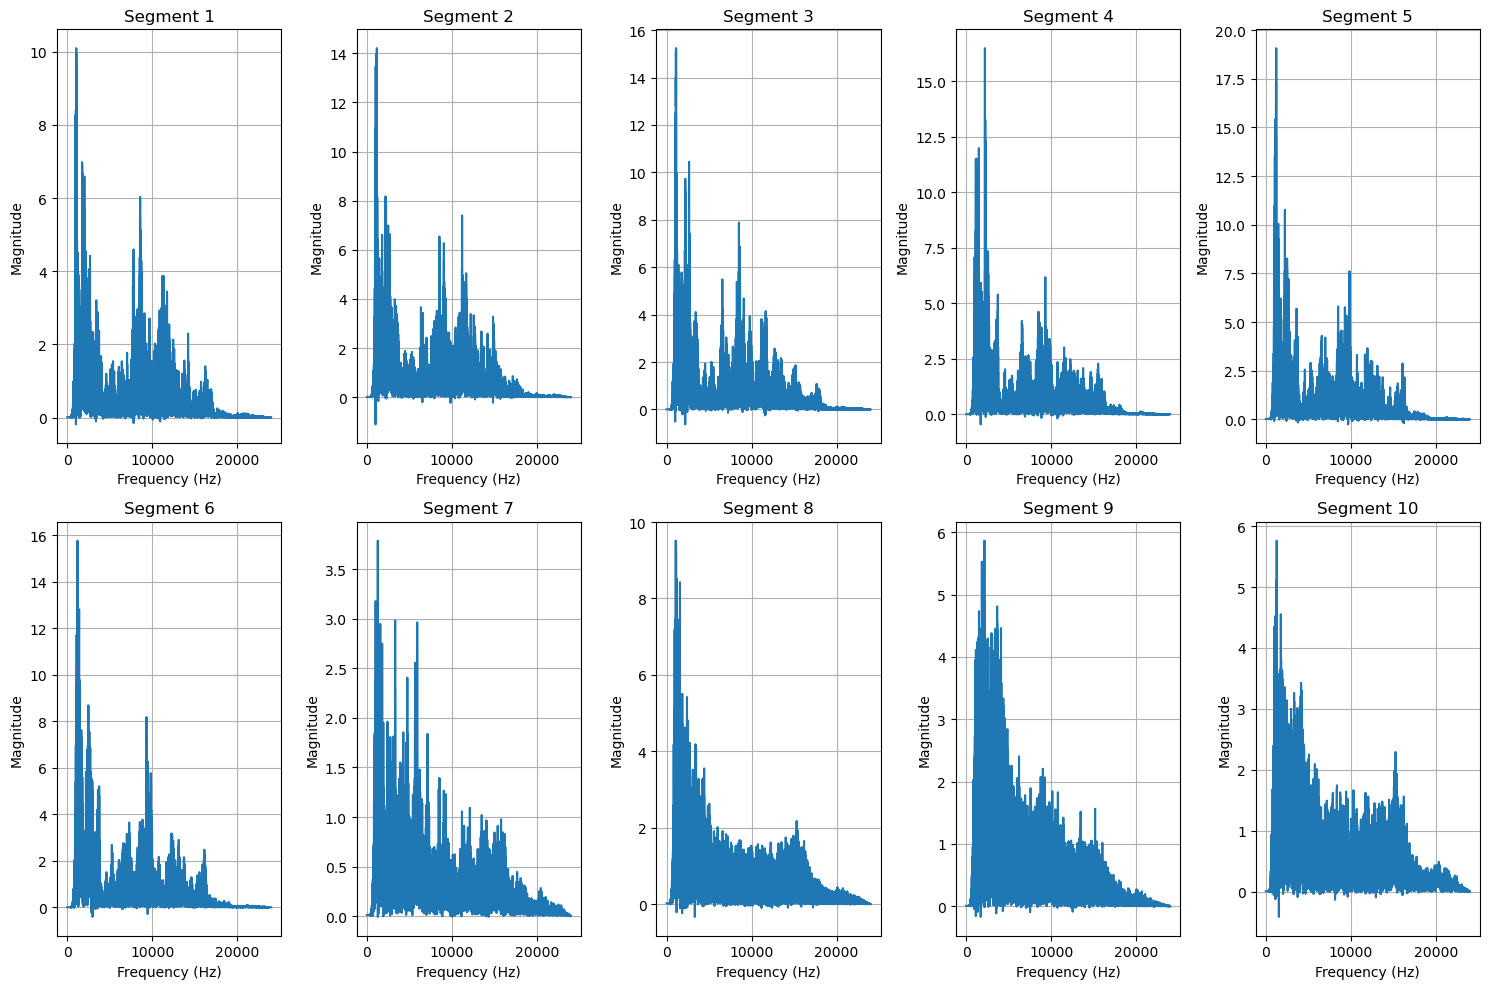

In [14]:
# plot_multiple_fft_magnitudes(processed_segments_fft, num_segments_to_plot=10)

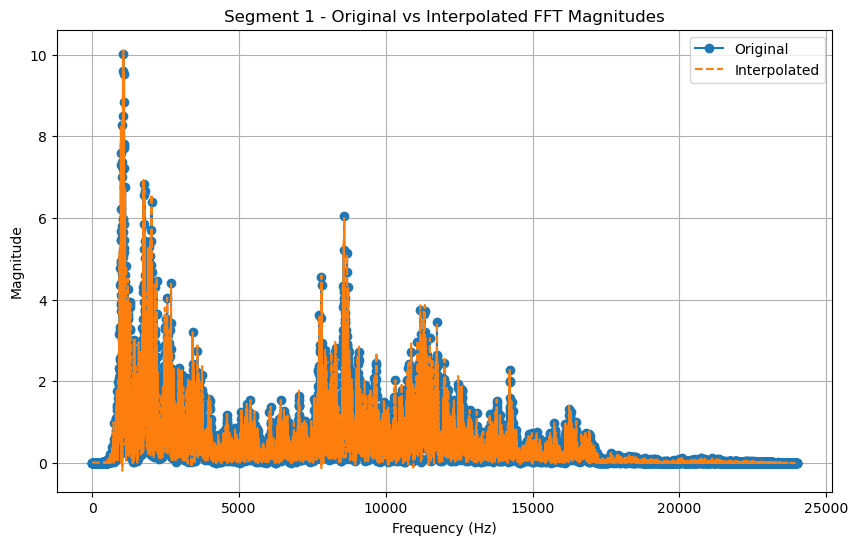

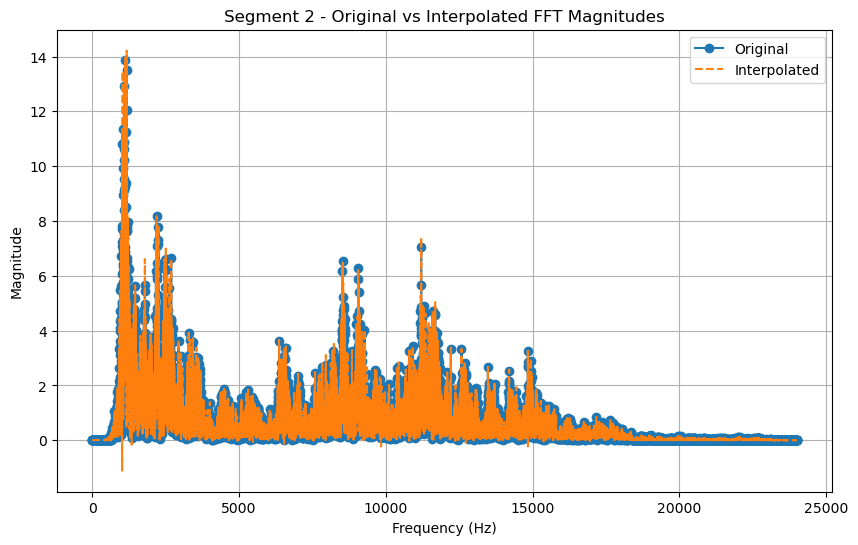

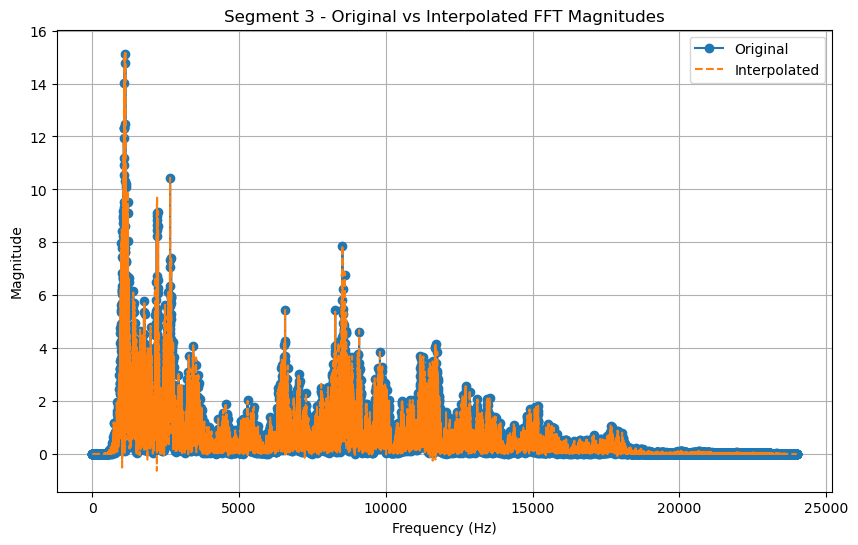

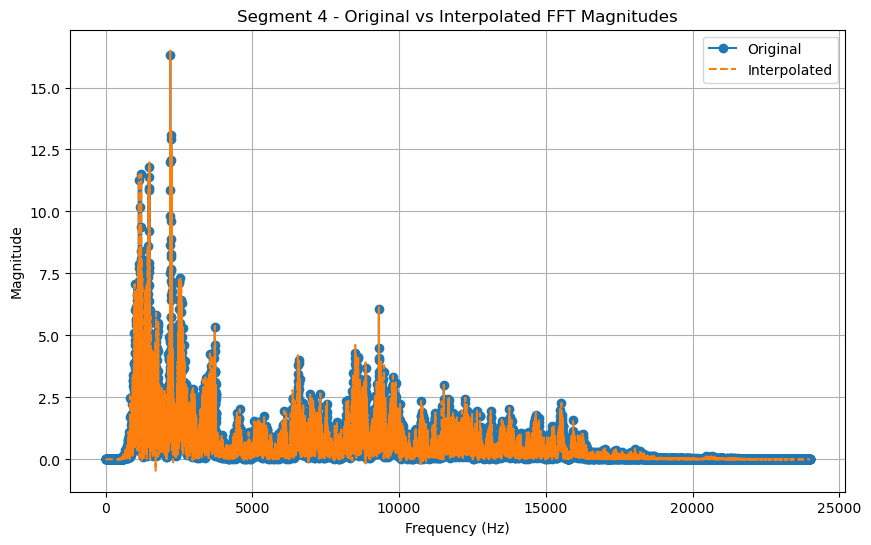

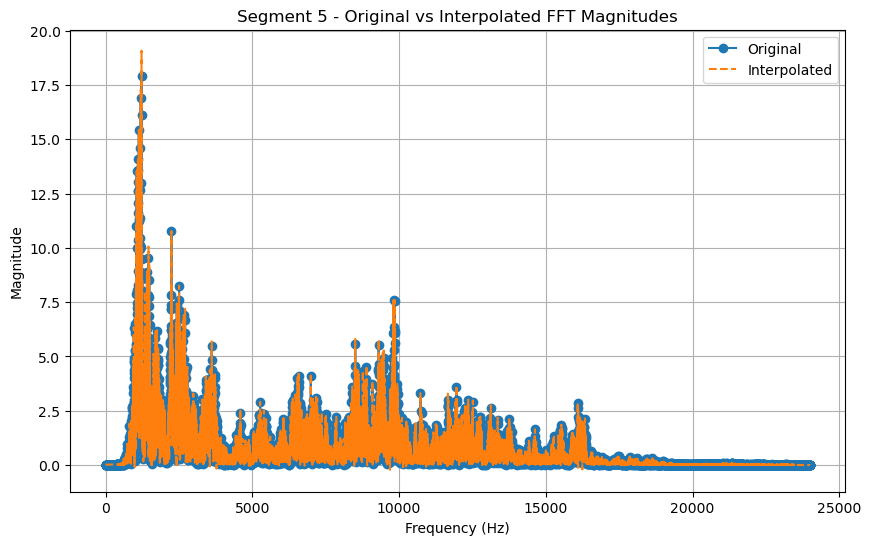

In [15]:
# examine artifacts
for i, segment in enumerate(processed_segments_fft[:5]):
    plt.figure(figsize=(10, 6))
    plt.plot(segment['fft_frequencies'], segment['fft_magnitude'], label='Original', marker='o')
    plt.plot(segment['common_frequencies'], segment['interpolated_fft_magnitude'], label='Interpolated', linestyle='--')
    plt.title(f"Segment {i + 1} - Original vs Interpolated FFT Magnitudes")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
errors = []
for segment in processed_segments_fft:
    interp_func = interp1d(segment['common_frequencies'], segment['interpolated_fft_magnitude'], 
                           kind='cubic', bounds_error=False, fill_value=0)
    interpolated_on_original = interp_func(segment['fft_frequencies'])
    error = np.sqrt(np.mean((segment['fft_magnitude'] - interpolated_on_original) ** 2))
    errors.append(error)

print(f"Mean RMSE: {np.mean(errors):.4f}, Max RMSE: {np.max(errors):.4f}")

Mean RMSE: 0.0009, Max RMSE: 0.0978


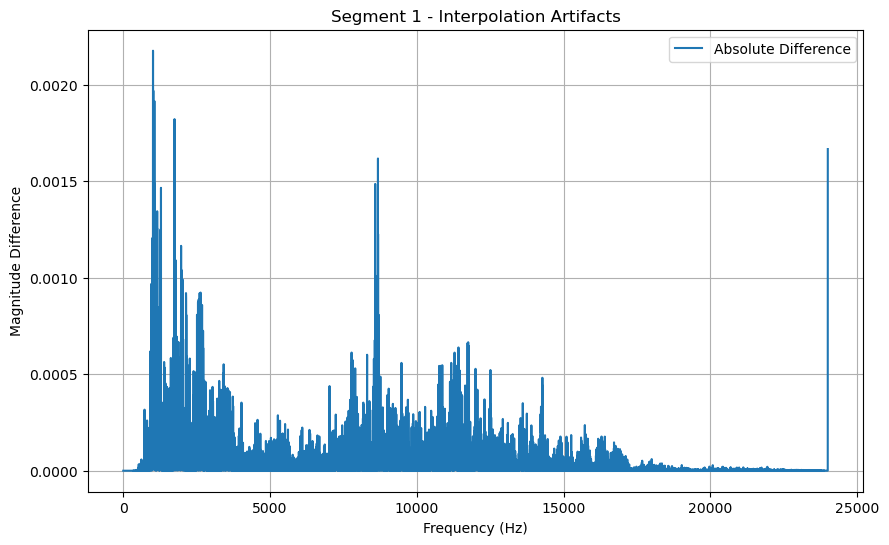

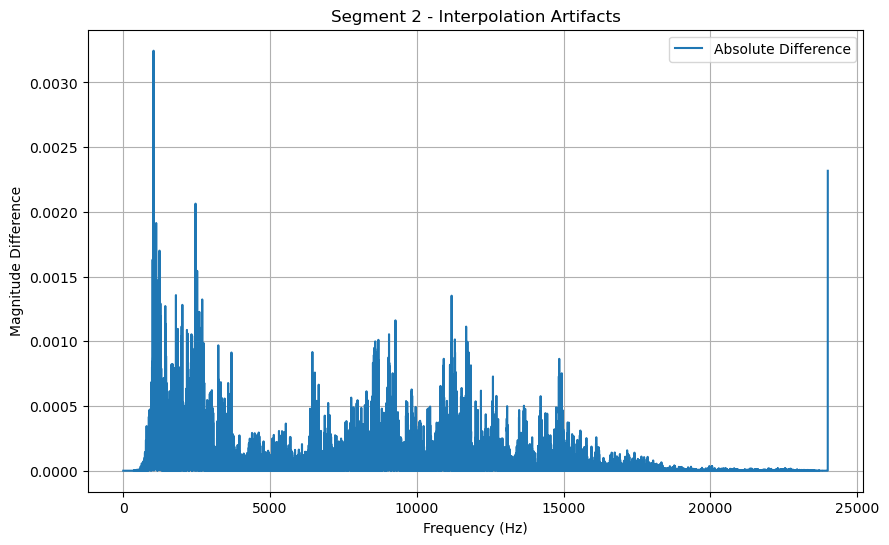

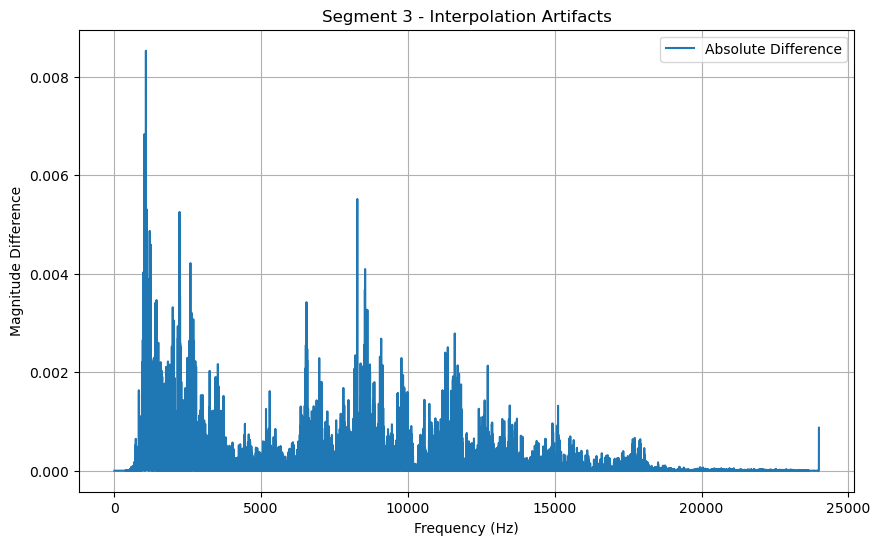

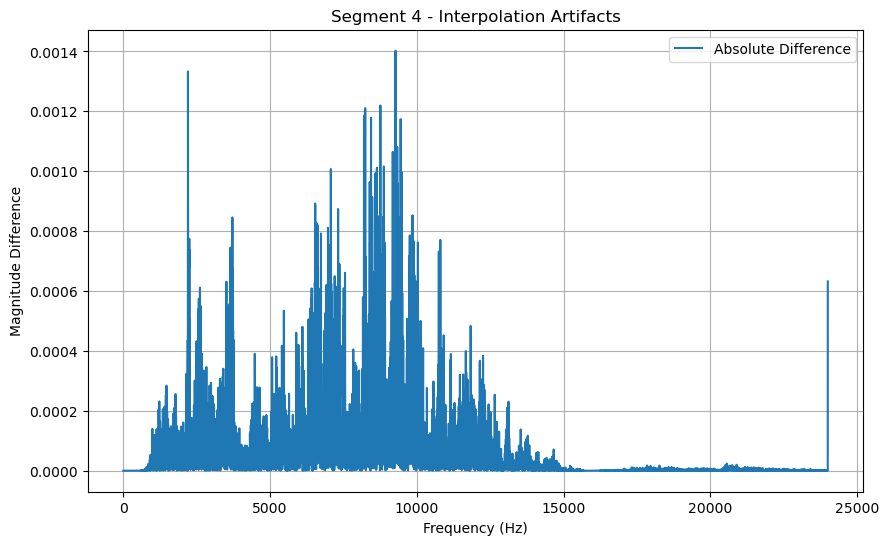

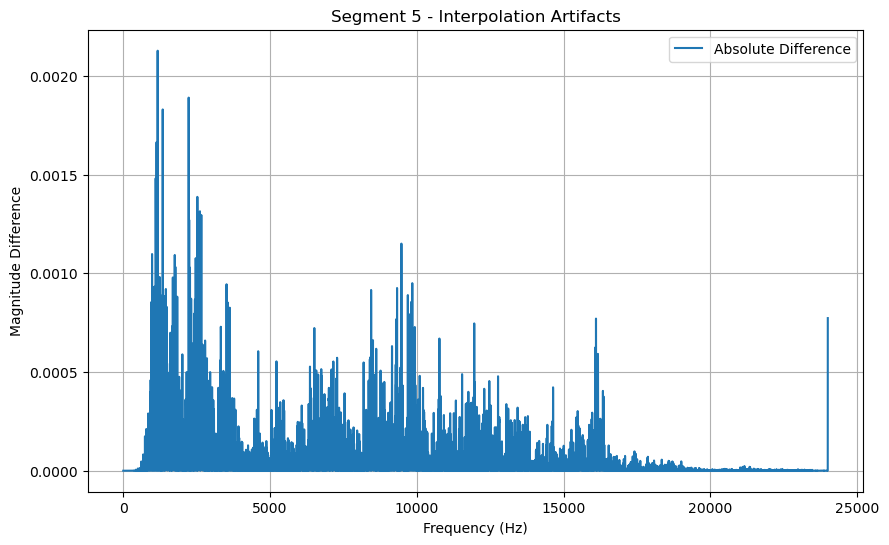

In [17]:
for i, segment in enumerate(processed_segments_fft[:5]):
    plt.figure(figsize=(10, 6))
    original_frequencies = segment['fft_frequencies']
    interp_func = interp1d(segment['common_frequencies'], segment['interpolated_fft_magnitude'], 
                           kind='cubic', bounds_error=False, fill_value=0)
    interpolated_on_original = interp_func(original_frequencies)
    differences = np.abs(segment['fft_magnitude'] - interpolated_on_original)

    plt.plot(original_frequencies, differences, label="Absolute Difference")
    plt.title(f"Segment {i + 1} - Interpolation Artifacts")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude Difference")
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
def spectral_clustering_workflow(processed_segments, n_clusters=5, source='fft'):
    if source == 'fft':
        print("Extracting and standardizing FFT magnitudes...")
        magnitudes = np.array([segment['interpolated_fft_magnitude'] for segment in processed_segments])
    elif source == 'DWT':
        print("Extracting and standardizing DWT magnitudes...")
        magnitudes = np.array([np.vstack(segment['padded_power_levels']).flatten() for segment in processed_segments])
    scaler = StandardScaler()
    magnitudes_scaled = scaler.fit_transform(magnitudes)

    print(f"Performing spectral clustering with {n_clusters} clusters...")
    spectral_clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='nearest_neighbors',
        random_state=42
    )
    labels = spectral_clustering.fit_predict(magnitudes_scaled)

    for i, segment in enumerate(processed_segments):
        segment['cluster'] = labels[i]

#     print("Visualizing cluster sizes...")
    unique_labels, counts = np.unique(labels, return_counts=True)
#     plt.figure(figsize=(8, 6))
#     plt.bar(unique_labels, counts)
#     plt.xlabel('Cluster')
#     plt.ylabel('Number of Segments')
#     plt.title('Cluster Sizes')
#     plt.show()

    print("Analyzing and visualizing average magnitudes per cluster...")
#     plt.figure(figsize=(10, 6))
    for cluster_id in unique_labels:
        if source == 'fft':
            cluster_magnitudes = [segment['interpolated_fft_magnitude'] for segment in processed_segments if segment['cluster'] == cluster_id]
        elif source == 'DWT':
            cluster_magnitudes = [segment['padded_power_levels'] for segment in processed_segments if segment['cluster'] == cluster_id]
        avg_magnitude = np.mean(cluster_magnitudes, axis=0)
#         plt.plot(avg_magnitude, label=f"Cluster {cluster_id}")

#     plt.xlabel('Frequency Bin')
#     plt.ylabel('Average Magnitude')
#     plt.title('Average FFT Magnitudes for Clusters')
#     plt.legend()
#     plt.grid()
#     plt.show()

    print("Grouping segments by clusters...")
    clusters = defaultdict(list)
    for segment in processed_segments:
        clusters[segment['cluster']].append(segment)

    return clusters

In [19]:
# # Run the clustering workflow
# n_clusters = 15
# clusters = spectral_clustering_workflow(processed_segments_fft, n_clusters=n_clusters)

# # Access clusters for further analysis
# for cluster_id, cluster_segments in clusters.items():
#     print(f"Cluster {cluster_id} contains {len(cluster_segments)} segments.")


In [20]:
# null distribution
def compute_null_distribution(processed_segments, n_clusters, num_iterations=100, ground_truth=None, source='fft'):
    if ground_truth is not None:
        observed_clusters = spectral_clustering_workflow(processed_segments, n_clusters=n_clusters, source=source)
        observed_labels = get_cluster_labels(observed_clusters)

        observed_score = adjusted_rand_score(ground_truth_labels, observed_labels)

        null_scores = []

        for i in range(num_iterations):
            print(f"Iteration {i + 1}/{num_iterations}...")

            shuffled_segments = shuffle_magnitude_values(processed_segments)
            null_clusters = spectral_clustering_workflow(shuffled_segments, n_clusters=n_clusters, source=source)
            null_labels = get_cluster_labels(null_clusters)

            similarity_score = adjusted_rand_score(ground_truth_labels, null_labels)
            null_scores.append(similarity_score)

        return null_scores, observed_score
    else:
        observed_clusters = spectral_clustering_workflow(processed_segments, n_clusters=n_clusters, source=source)
        observed_labels = get_cluster_labels(observed_clusters)

        observed_score = adjusted_rand_score(observed_labels, observed_labels)
        null_scores = []

        for i in range(num_iterations):
            print(f"Iteration {i + 1}/{num_iterations}...")

            shuffled_segments = shuffle_magnitude_values(processed_segments)

            null_clusters = spectral_clustering_workflow(shuffled_segments, n_clusters=n_clusters)
            null_labels = get_cluster_labels(null_clusters)

            similarity_score = adjusted_rand_score(observed_labels, null_labels)
            null_scores.append(similarity_score)

        return null_scores, observed_score

def get_cluster_labels(clusters):
    labels = []
    for cluster_id, cluster_segments in clusters.items():
        labels.extend([cluster_id] * len(cluster_segments))
    return labels

# Visualize results
def visualize_null_distribution(null_scores, observed_score):    
    plt.hist(null_scores, bins=20, alpha=0.7, label='Null Distribution')
    plt.axvline(observed_score, color='red', linestyle='dashed', label='Observed Score')
    plt.xlabel('ARI')
    plt.ylabel('Frequency')
    plt.title('Null Distribution of Clustering Similarity')
    plt.legend()
    plt.show()
    
def shuffle_magnitude_values(processed_segments):
    shuffled_segments = deepcopy(processed_segments)
    
    for segment in shuffled_segments:
        if 'interpolated_fft_magnitude' in segment:
            magnitude = segment['interpolated_fft_magnitude']
            segment['interpolated_fft_magnitude'] = np.random.permutation(magnitude)
    
    return shuffled_segments

In [21]:
# 'ground truth'
pkl_output_path = '../audios/lab_audios/first_batch/200RandomSegments.pkl'
with open(pkl_output_path, 'rb') as pkl_file:
    random_segments = pickle.load(pkl_file)
    
# processed_random_segments_fft = process_individual_snippets_with_fft(random_segments[:100], file_names)

# with open(f'{folder_path}processed_random_segments_FFT.pkl', 'wb') as file:
#     pickle.dump(processed_random_segments_fft, file)
    
with open(f'{folder_path}processed_random_segments_FFT.pkl', 'rb') as file:
    processed_random_segments_fft = pickle.load(file)

for segment in processed_random_segments_fft:
    # Get the fft_frequencies and fft_magnitude fields
    fft_frequencies = segment['fft_frequencies']
    fft_magnitude = segment['fft_magnitude']
    
    # Filter for non-negative frequencies
    non_negative_indices = fft_frequencies >= 0
    segment['fft_frequencies'] = fft_frequencies[non_negative_indices]
    segment['fft_magnitude'] = fft_magnitude[non_negative_indices]

print("Negative frequencies have been removed from all segments.")

finest_delta_f = min([np.min(np.diff(segment['fft_frequencies'])) for segment in processed_random_segments_fft])

min_freq = min([min(segment['fft_frequencies']) for segment in processed_random_segments_fft])
max_freq = max([max(segment['fft_frequencies']) for segment in processed_random_segments_fft])

common_frequencies = np.arange(min_freq, max_freq, finest_delta_f)

processed_random_segments_fft = interpolate_fft_magnitudes(processed_random_segments_fft, common_frequencies)

Negative frequencies have been removed from all segments.


In [22]:
# padding
def process_individual_snippets_with_fft_padding(all_segments, file_names, sr=None):
    processed_segments_fft = []
    max_length = 0

    # Step 1: Determine the maximum snippet length
    print("Calculating maximum snippet length...")
    for file_name in file_names:
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]
        for segment in file_segments:
            start_idx = int(segment['start_time'] * original_sr)
            end_idx = int(segment['end_time'] * original_sr)
            snippet_length = end_idx - start_idx
            max_length = max(max_length, snippet_length)

    print(f"Max snippet length: {max_length} samples")

    # Step 2: Process each segment, pad, and perform FFT
    file_idx = 0
    while file_idx < len(file_names):
        file_name = file_names[file_idx]
        print(f"Loading file: {file_name}")
        
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            file_idx += 1
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]

        for idx, segment in enumerate(file_segments):
            start_time = segment['start_time']
            end_time = segment['end_time']
            
            print(f"Processing snippet {idx + 1}/{len(file_segments)}: {start_time:.2f}s to {end_time:.2f}s")

            start_idx = int(start_time * original_sr)
            end_idx = int(end_time * original_sr)
            
            snippet = y[start_idx:end_idx]
            
            # Step 3: Pad the snippet to max_length with its mean value, centered
            padding_value = np.mean(snippet)
            total_padding = max_length - len(snippet)
            padding_left = total_padding // 2
            padding_right = total_padding - padding_left
            padded_snippet = np.pad(
                snippet, 
                (padding_left, padding_right), 
                mode='constant', 
                constant_values=padding_value
            )
            
            # Step 4: Perform FFT on the padded snippet
            fft_result = np.fft.fft(padded_snippet)
            fft_magnitude = np.abs(fft_result)
            fft_frequencies = np.fft.fftfreq(len(padded_snippet), d=1/original_sr)  # Get frequencies
            
            processed_segments_fft.append({
                'file_name': file_name,
                'start_time': start_time,
                'end_time': end_time,
                'padded_signal': padded_snippet,
                'fft_magnitude': fft_magnitude,
                'fft_frequencies': fft_frequencies
            })

        file_idx += 1

    return processed_segments_fft

In [23]:
processed_random_segments_fft_padding = process_individual_snippets_with_fft_padding(random_segments[:100], file_names)

for segment in processed_random_segments_fft_padding:
    # Get the fft_frequencies and fft_magnitude fields
    fft_frequencies = segment['fft_frequencies']
    fft_magnitude = segment['fft_magnitude']
    
    # Filter for non-negative frequencies
    non_negative_indices = fft_frequencies >= 0
    segment['fft_frequencies'] = fft_frequencies[non_negative_indices]
    segment['fft_magnitude'] = fft_magnitude[non_negative_indices]

print("Negative frequencies have been removed from all segments.")

Calculating maximum snippet length...
Max snippet length: 131518 samples
Loading file: ../audios/lab_audios/first_batch/recording_20240927_204919-01.wav
Processing snippet 1/6: 1251.76s to 1252.37s
Processing snippet 2/6: 572.95s to 573.25s
Processing snippet 3/6: 3110.80s to 3112.54s
Processing snippet 4/6: 3758.66s to 3758.92s
Processing snippet 5/6: 3002.94s to 3005.38s
Processing snippet 6/6: 595.62s to 596.06s
Loading file: ../audios/lab_audios/first_batch/recording_20240927_204919-02.wav
Processing snippet 1/5: 2739.21s to 2739.65s
Processing snippet 2/5: 4938.77s to 4939.35s
Processing snippet 3/5: 5359.68s to 5360.16s
Processing snippet 4/5: 614.03s to 614.35s
Processing snippet 5/5: 2447.52s to 2447.78s
Loading file: ../audios/lab_audios/first_batch/recording_20240927_204919-03.wav
Processing snippet 1/7: 1232.21s to 1232.61s
Processing snippet 2/7: 1611.40s to 1611.86s
Processing snippet 3/7: 2910.39s to 2910.55s
Processing snippet 4/7: 4238.25s to 4238.76s
Processing snippet

In [42]:
frequency_resolutions = verify_frequency_resolution(processed_random_segments_fft_padding)

Frequency resolution is consistent: 0.36 Hz


In [43]:
# with open(f'{folder_path}processed_random_segments_FFT_padding.pkl', 'wb') as file:
#     pickle.dump(processed_random_segments_fft_padding, file)

In [51]:
def create_padded_fft_magnitude_from_padding(processed_segments_fft, processed_segments_fft_padding):
    # Ensure both lists have the same length
    if len(processed_segments_fft) != len(processed_segments_fft_padding):
        raise ValueError("The lengths of processed_segments_fft and processed_segments_fft_padding must be the same.")
    
    for segment, padding_segment in zip(processed_segments_fft, processed_segments_fft_padding):
        # Get the fft_magnitude from the padding dataset
        fft_magnitude_padding = padding_segment['fft_magnitude']
        
        # Add the padded_fft_magnitude to the original dataset
        segment['padded_fft_magnitude'] = fft_magnitude_padding

    return processed_segments_fft

In [52]:
processed_random_segments_fft = create_padded_fft_magnitude_from_padding(
    processed_random_segments_fft,
    processed_random_segments_fft_padding
)

In [53]:
print(processed_random_segments_fft[0])

{'file_name': '../audios/lab_audios/first_batch/recording_20240927_204919-01.wav', 'start_time': 1251.7645351473923, 'end_time': 1252.368253968254, 'fft_magnitude': array([0.00666906, 0.00666905, 0.00666905, ..., 0.00032855, 0.00193274,
       0.00085879]), 'fft_frequencies': array([0.00000000e+00, 1.65637186e+00, 3.31274371e+00, ...,
       2.39958591e+04, 2.39975154e+04, 2.39991718e+04]), 'common_frequencies': array([0.00000000e+00, 3.64969054e-01, 7.29938107e-01, ...,
       2.39989051e+04, 2.39992701e+04, 2.39996350e+04]), 'interpolated_fft_magnitude': array([0.00666906, 0.00666906, 0.00666906, ..., 0.00157452, 0.        ,
       0.        ]), 'padded_fft_magnitude': array([0.03026678, 0.0014385 , 0.00383812, ..., 0.00085785, 0.0008449 ,
       0.00076431])}


In [56]:
def plot_multiple_fft_magnitudes(segments, num_segments_to_plot=10):
    # Plot padded FFT magnitudes
    plt.figure(figsize=(15, 10))
    for i, segment in enumerate(segments[:num_segments_to_plot], start=1):
        if 'padded_fft_magnitude' in segment:
            fft_frequencies = segment['common_frequencies']
            padded_fft_magnitude = segment['padded_fft_magnitude']
            
            plt.plot(fft_frequencies, padded_fft_magnitude, label=f"Segment {i}")
    
    plt.title("Padded FFT Magnitudes")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()

    # Plot interpolated FFT magnitudes
    plt.figure(figsize=(15, 10))
    for i, segment in enumerate(segments[:num_segments_to_plot], start=1):
        if 'interpolated_fft_magnitude' in segment:
            fft_frequencies = segment['common_frequencies']
            interpolated_fft_magnitude = segment['interpolated_fft_magnitude']
            
            plt.plot(fft_frequencies, interpolated_fft_magnitude, label=f"Segment {i}")
    
    plt.title("Interpolated FFT Magnitudes")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()

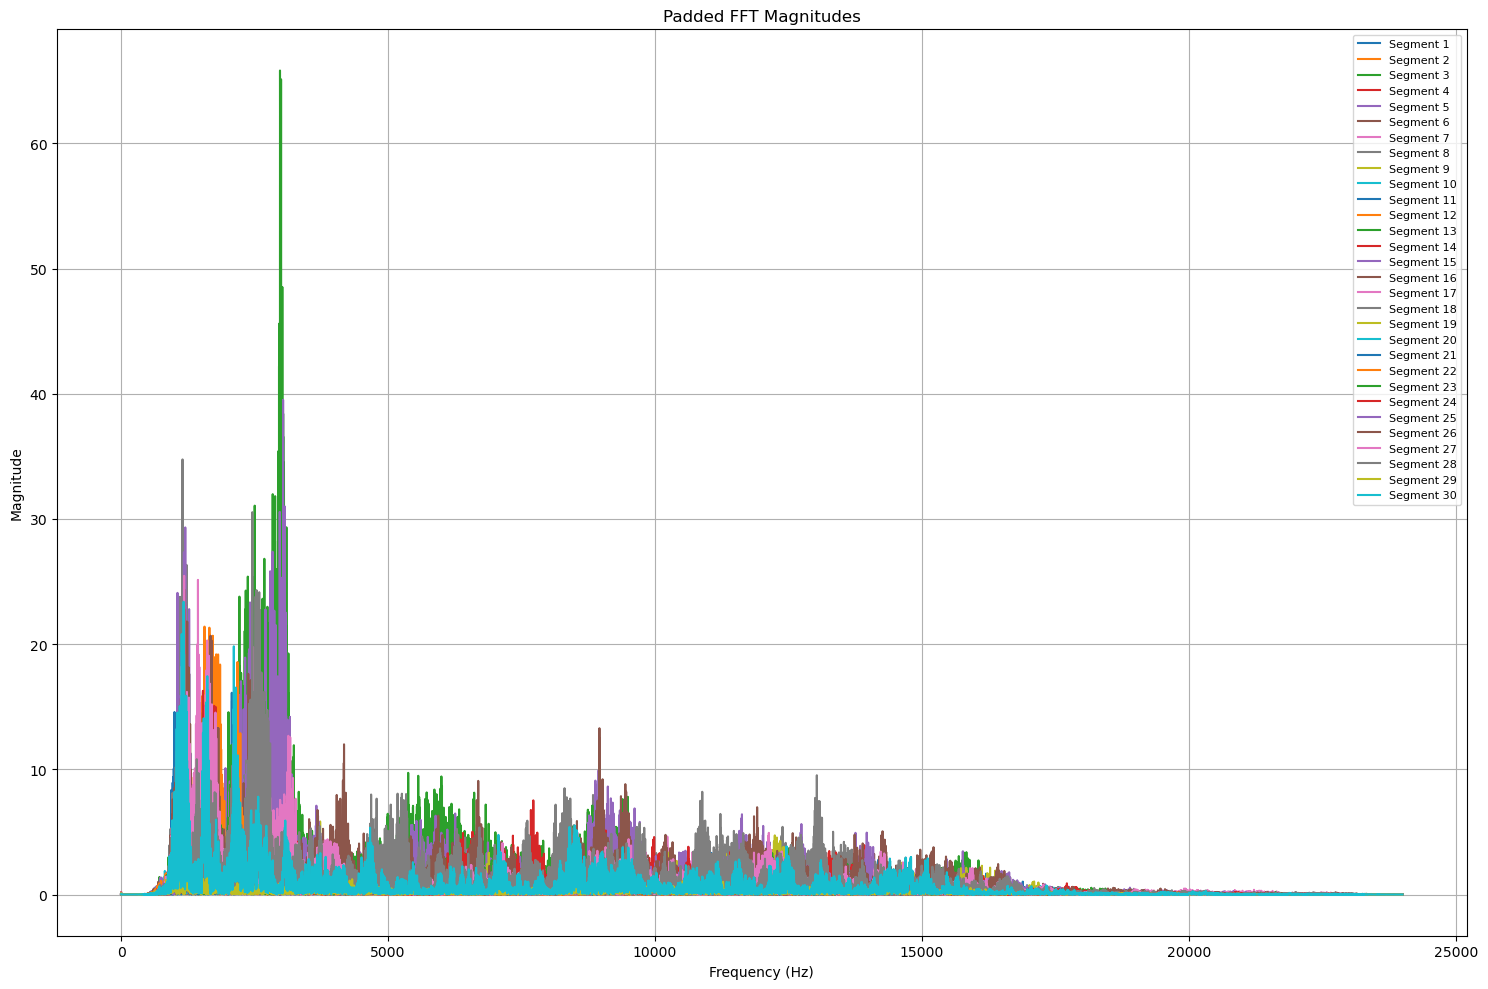

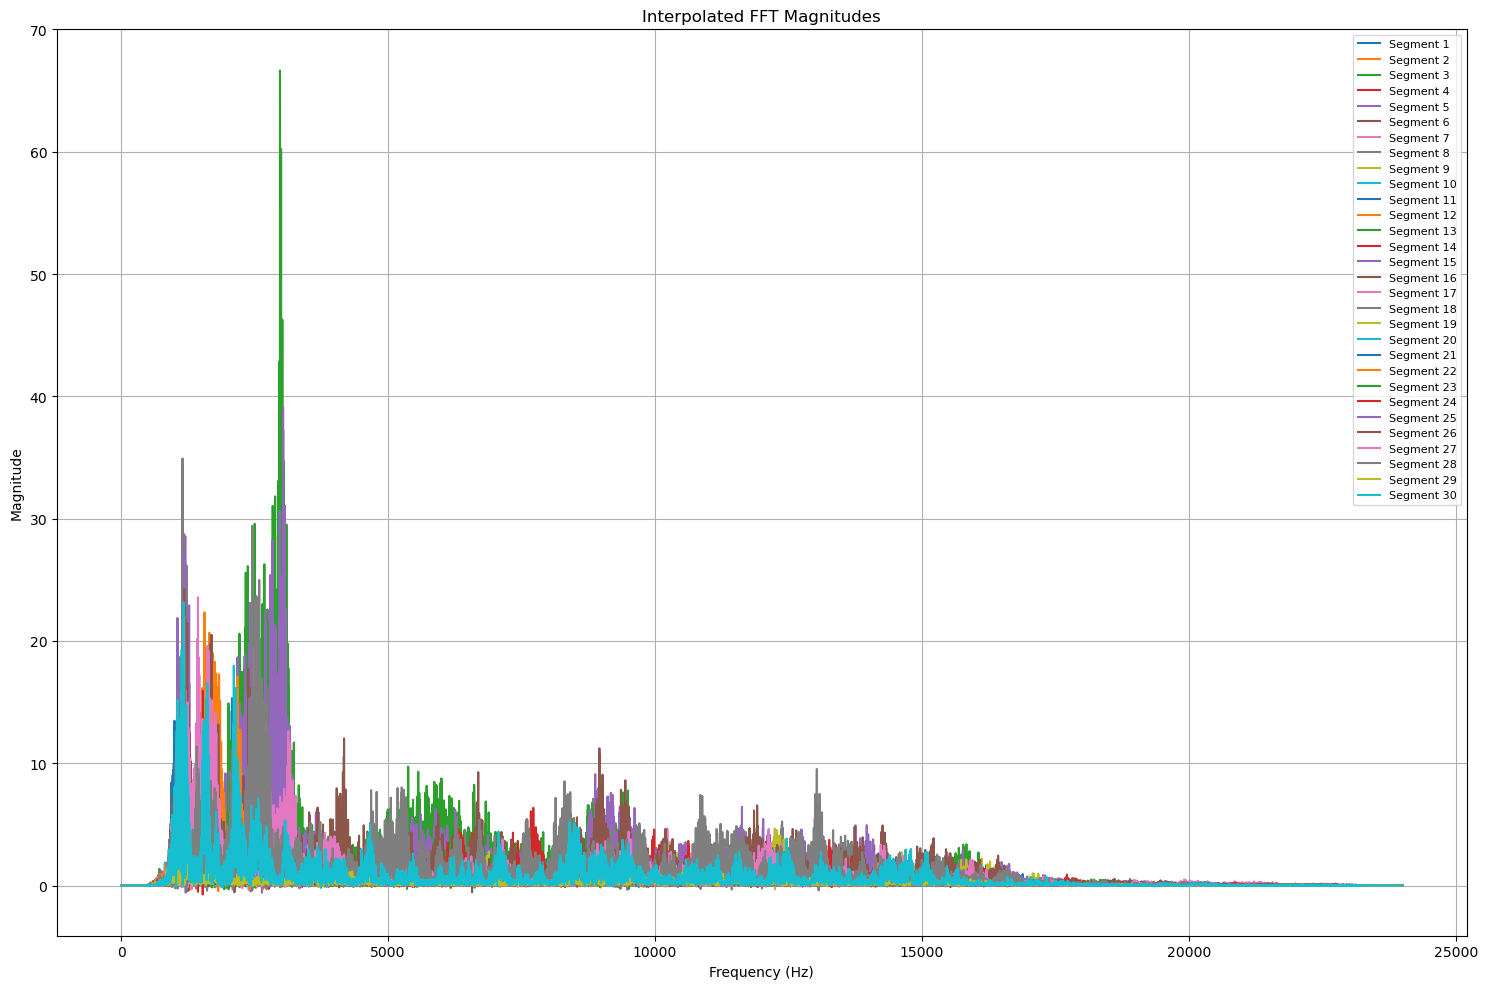

In [57]:
plot_multiple_fft_magnitudes(processed_random_segments_fft, num_segments_to_plot=30)

In [58]:
# put together to compare
def plot_padded_and_interpolated_for_each_segment(segments, num_segments_to_plot=10):
    for i, segment in enumerate(segments[:num_segments_to_plot], start=1):
        plt.figure(figsize=(15, 6))
        
        if 'padded_fft_magnitude' in segment:
            fft_frequencies = segment['common_frequencies']
            padded_fft_magnitude = segment['padded_fft_magnitude']
            plt.plot(fft_frequencies, padded_fft_magnitude, label="Padded FFT Magnitude", color='blue')
        
        if 'interpolated_fft_magnitude' in segment:
            fft_frequencies = segment['common_frequencies']
            interpolated_fft_magnitude = segment['interpolated_fft_magnitude']
            plt.plot(fft_frequencies, interpolated_fft_magnitude, label="Interpolated FFT Magnitude", color='orange')
        
        plt.title(f"Segment {i}: Padded vs Interpolated FFT Magnitudes")
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.legend(loc='upper right', fontsize=10)
        plt.tight_layout()
        plt.show()

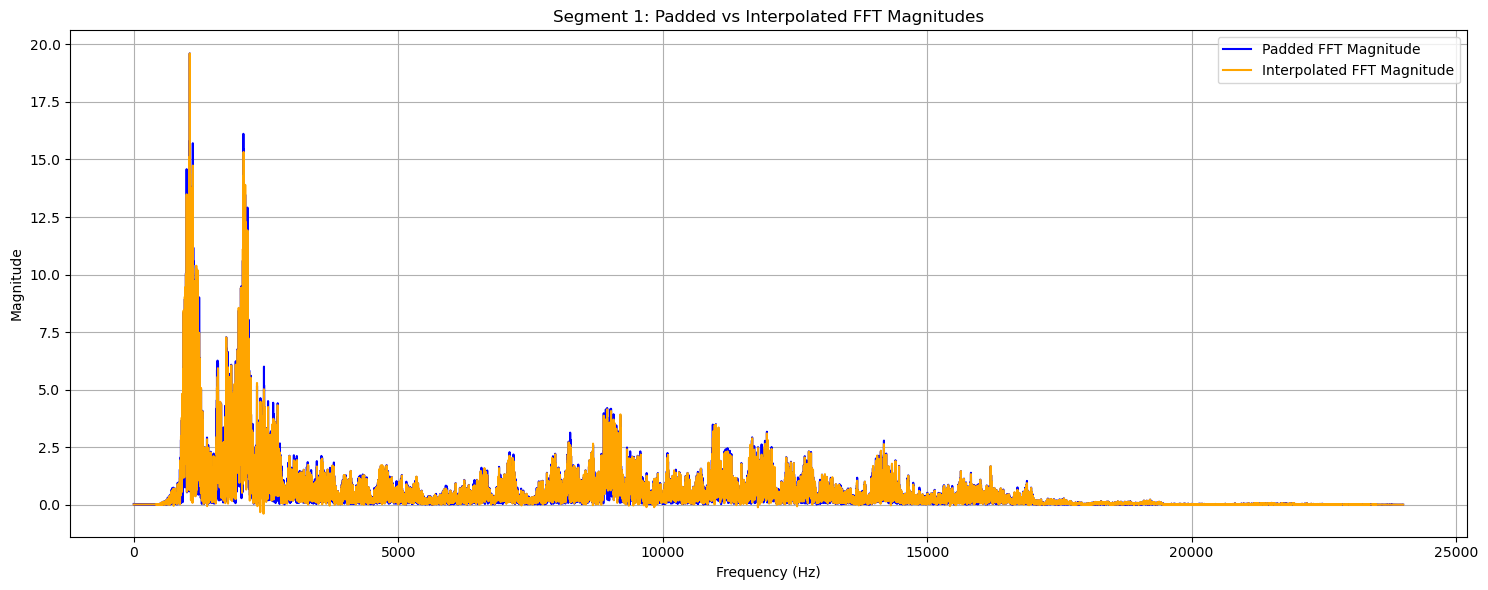

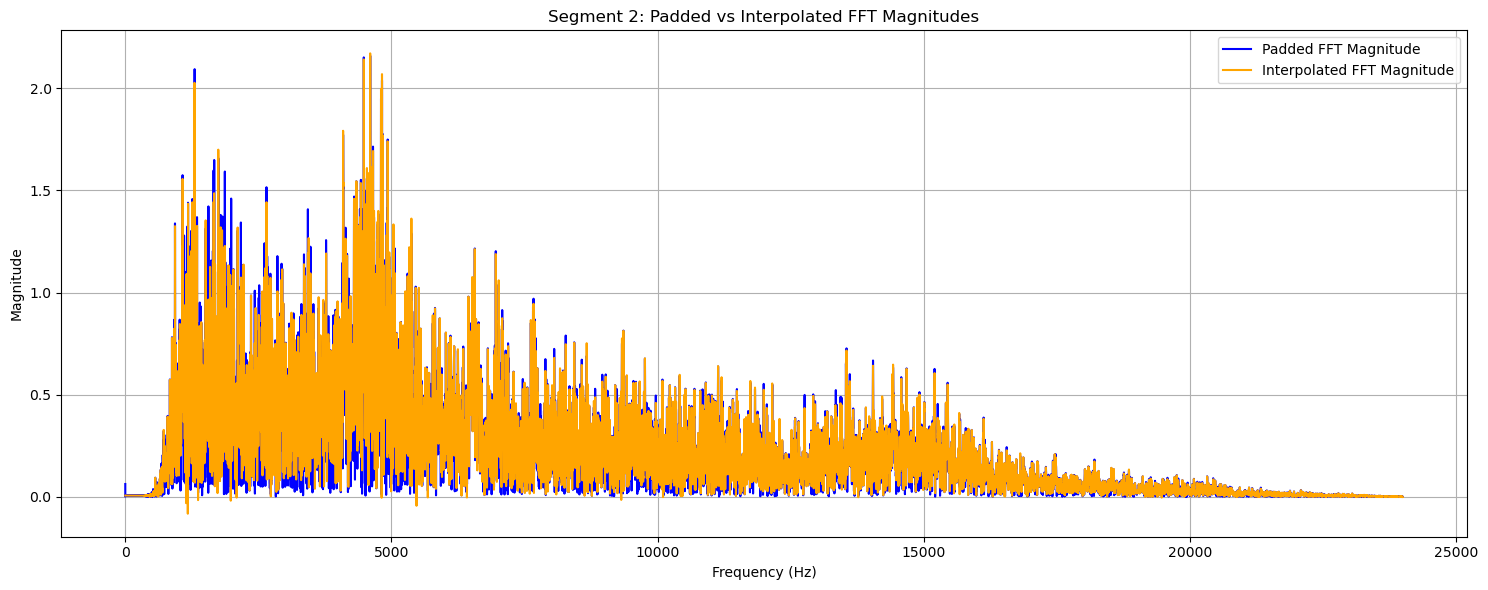

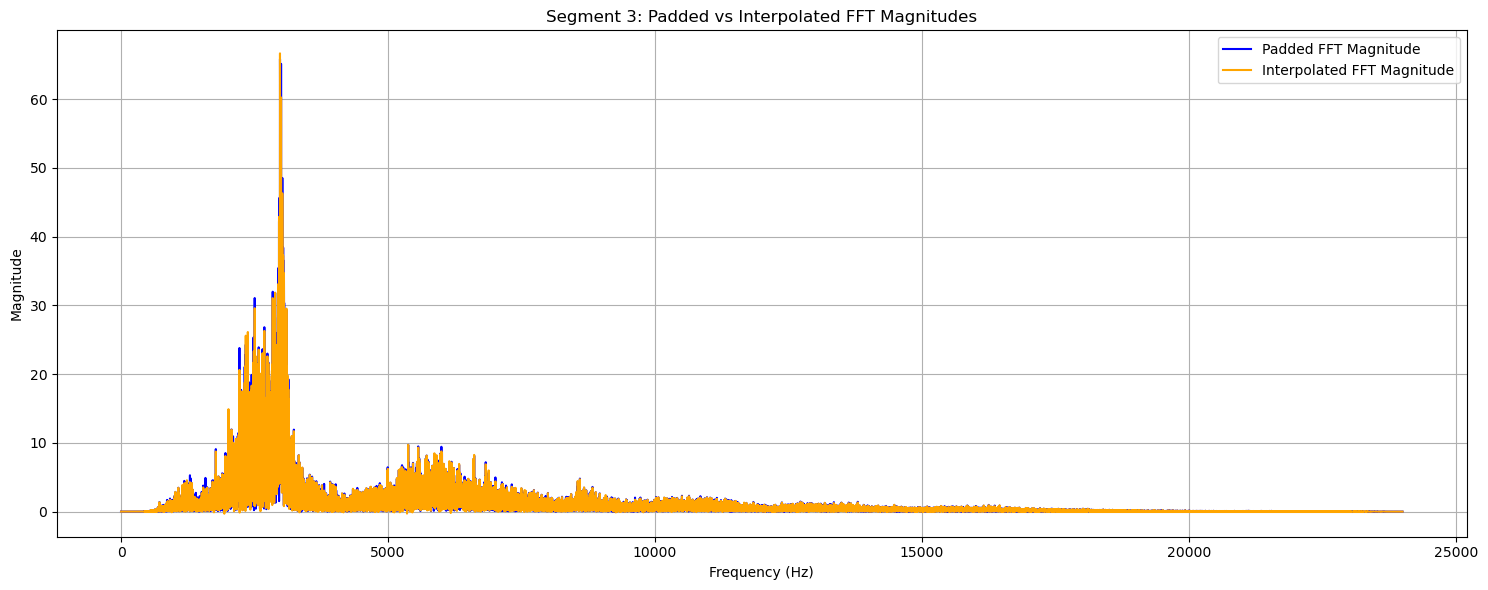

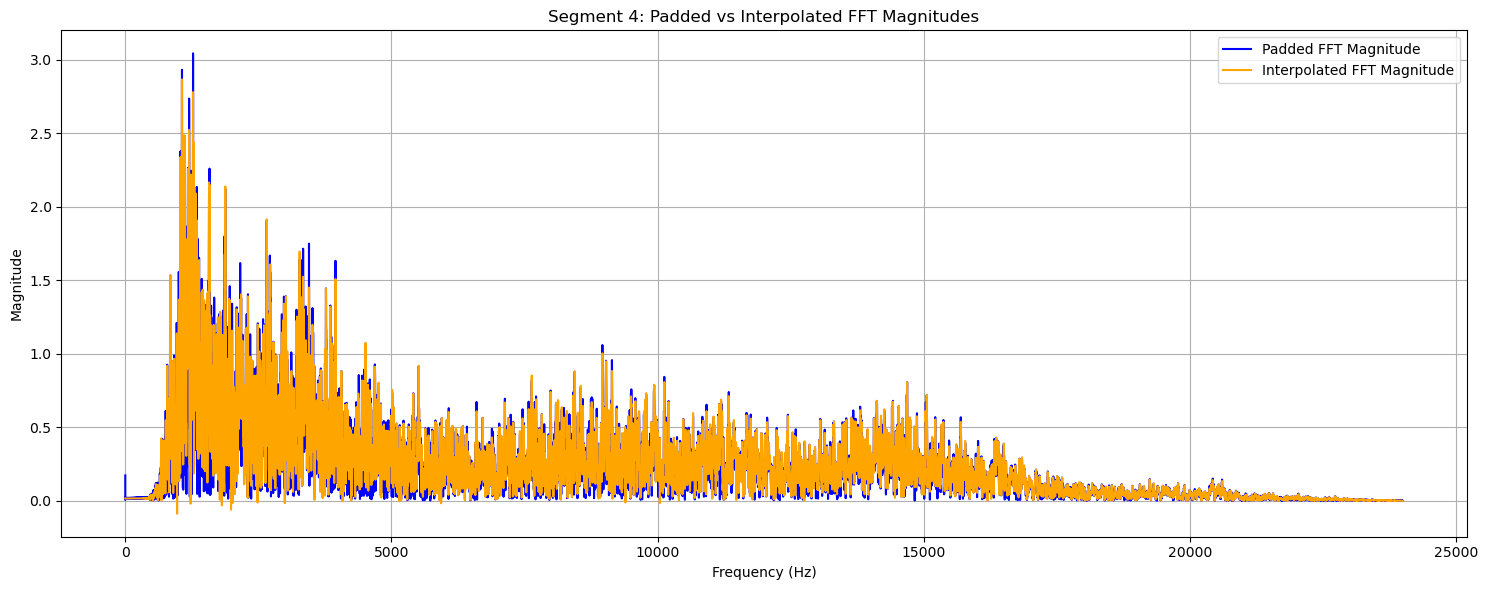

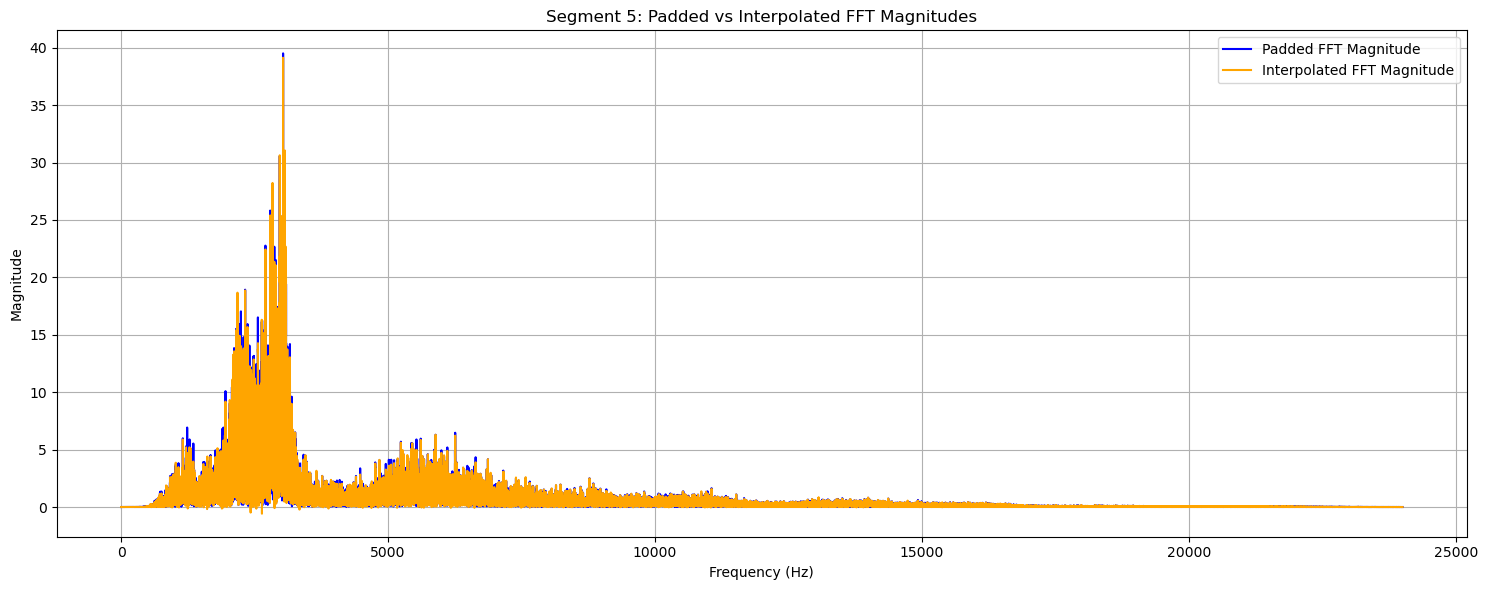

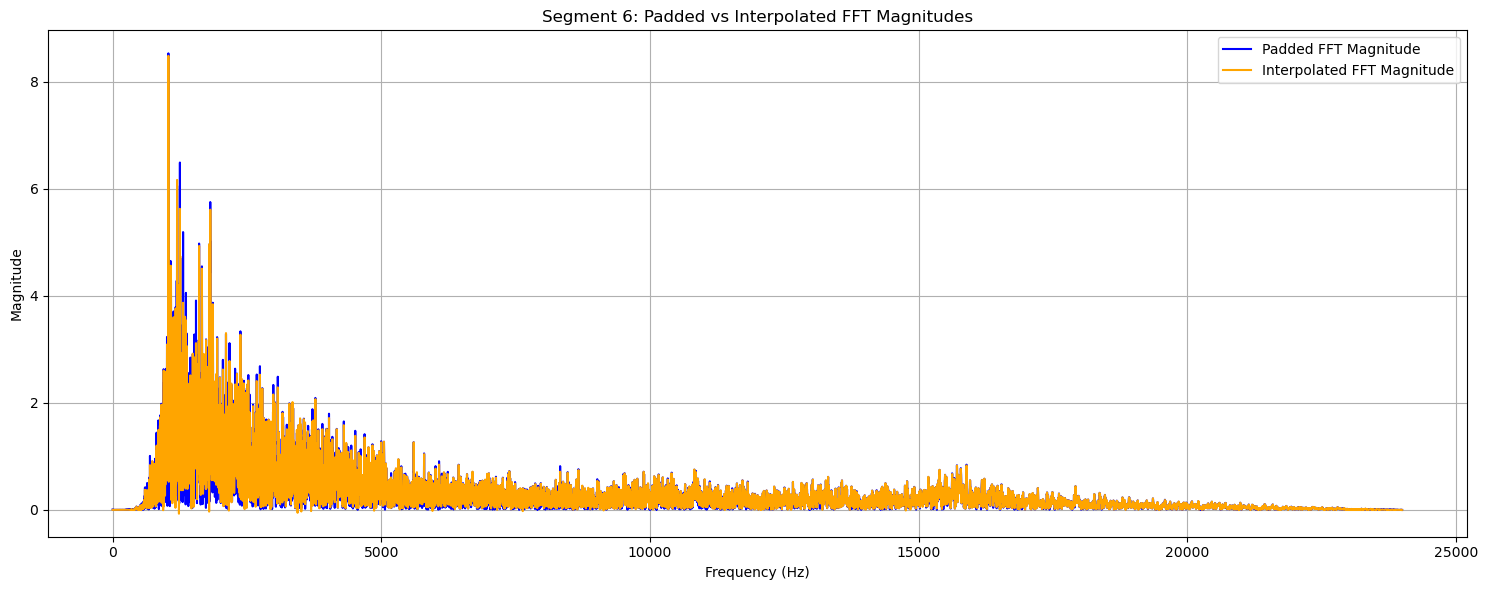

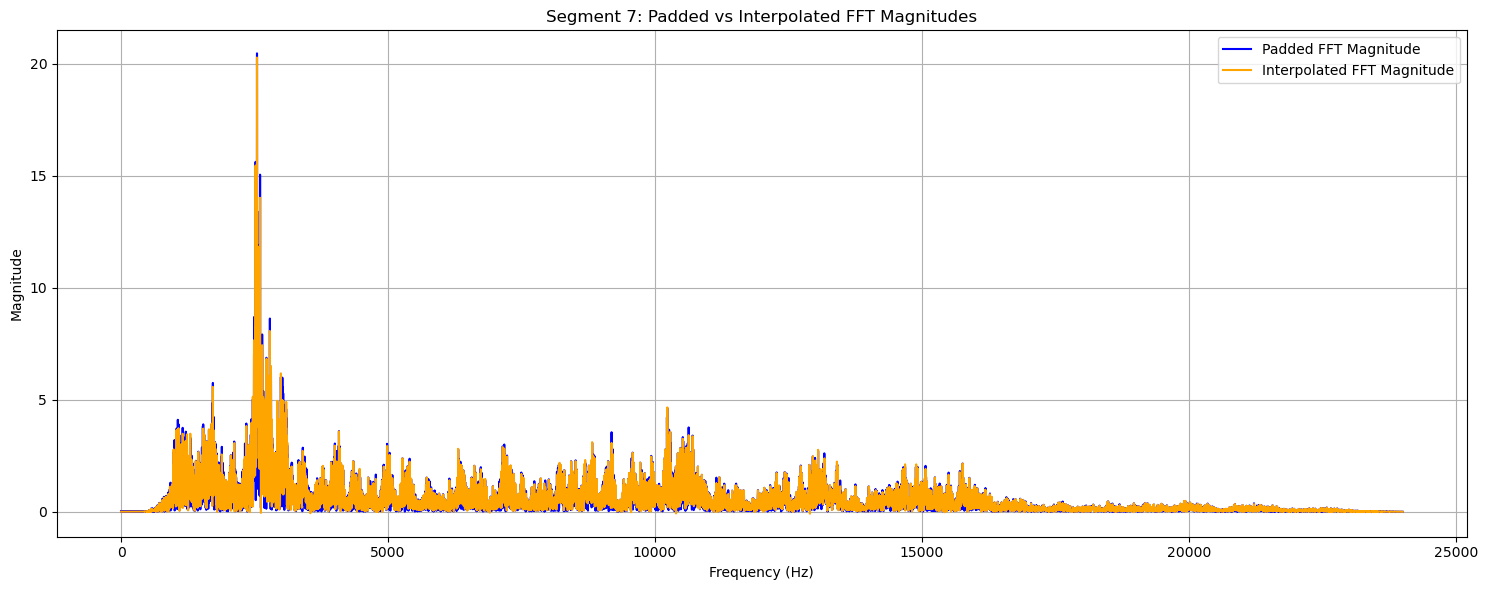

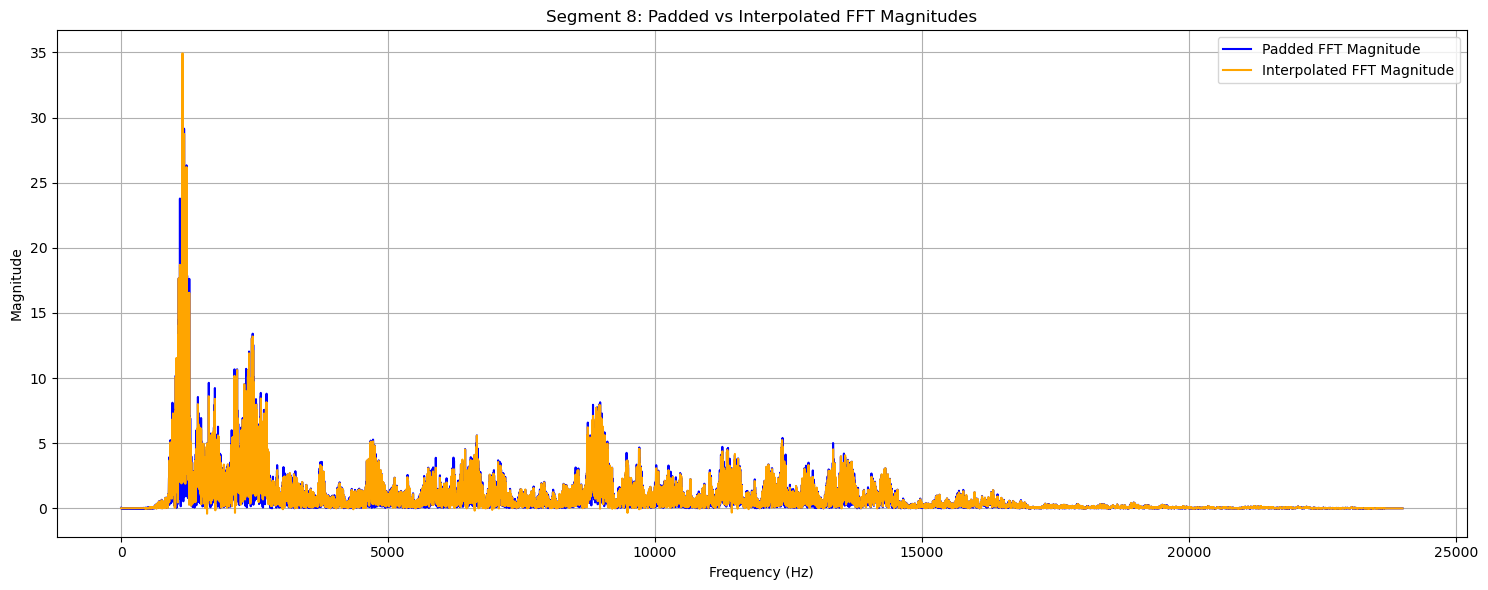

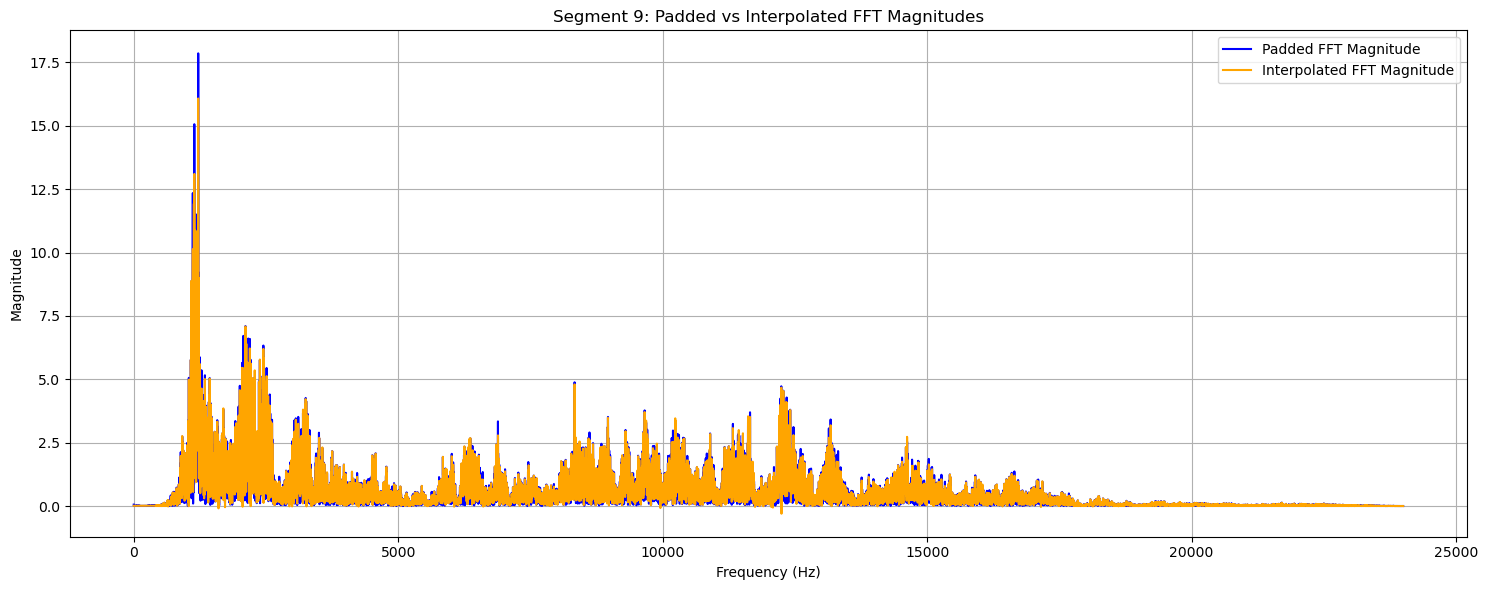

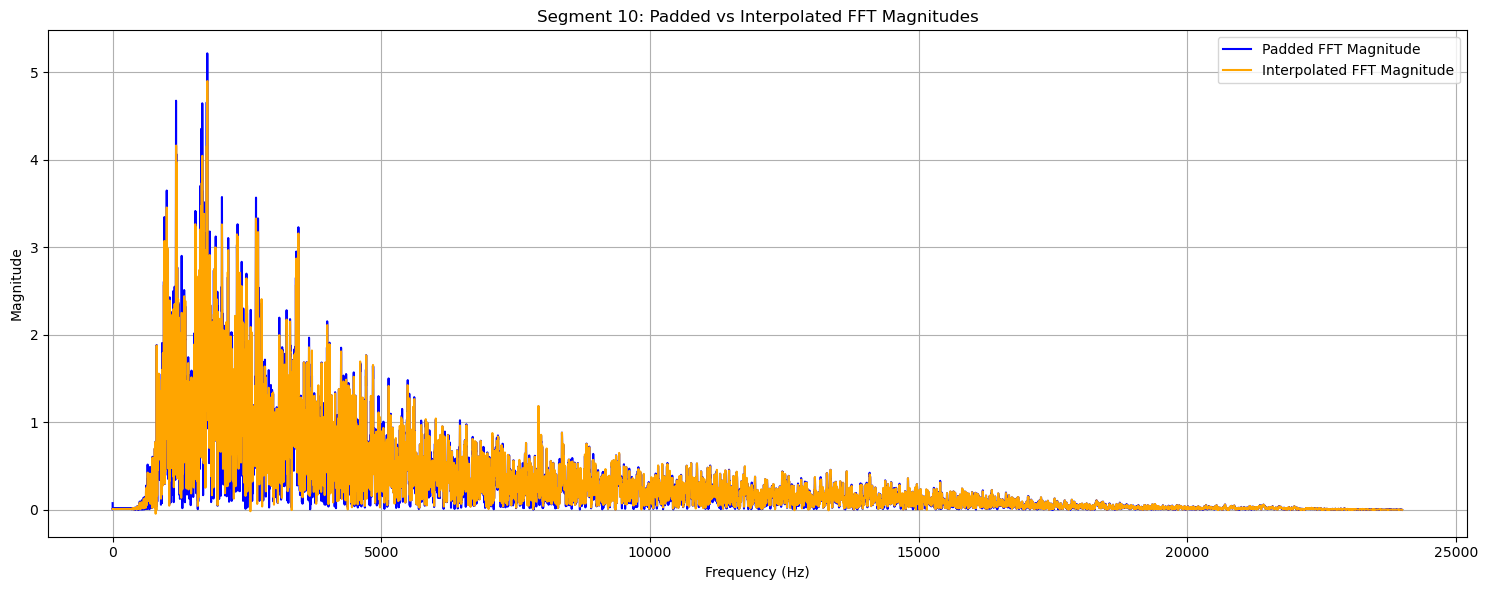

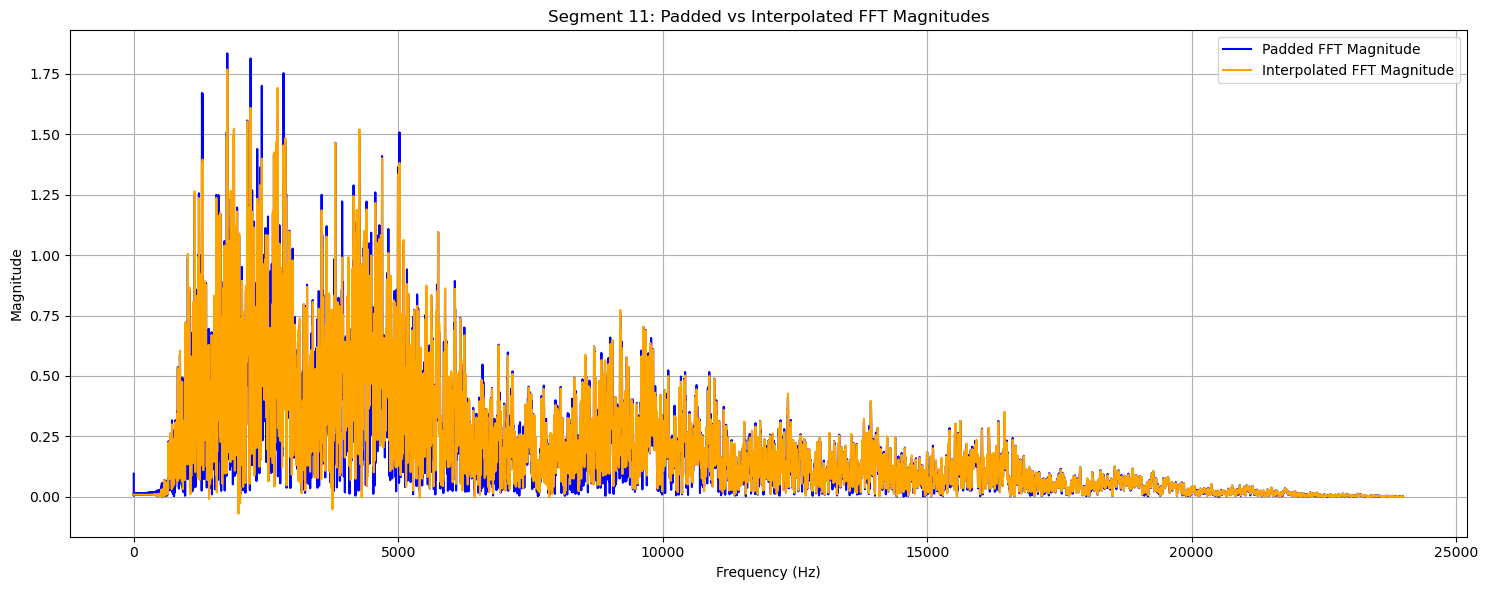

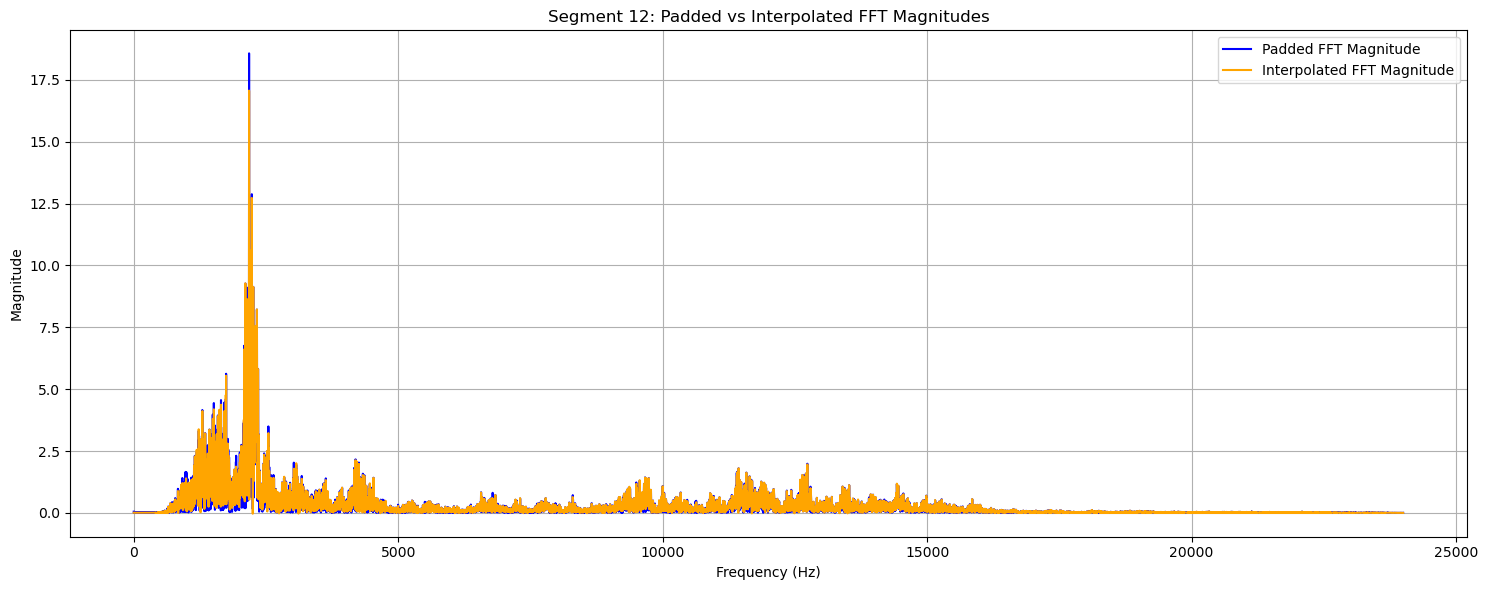

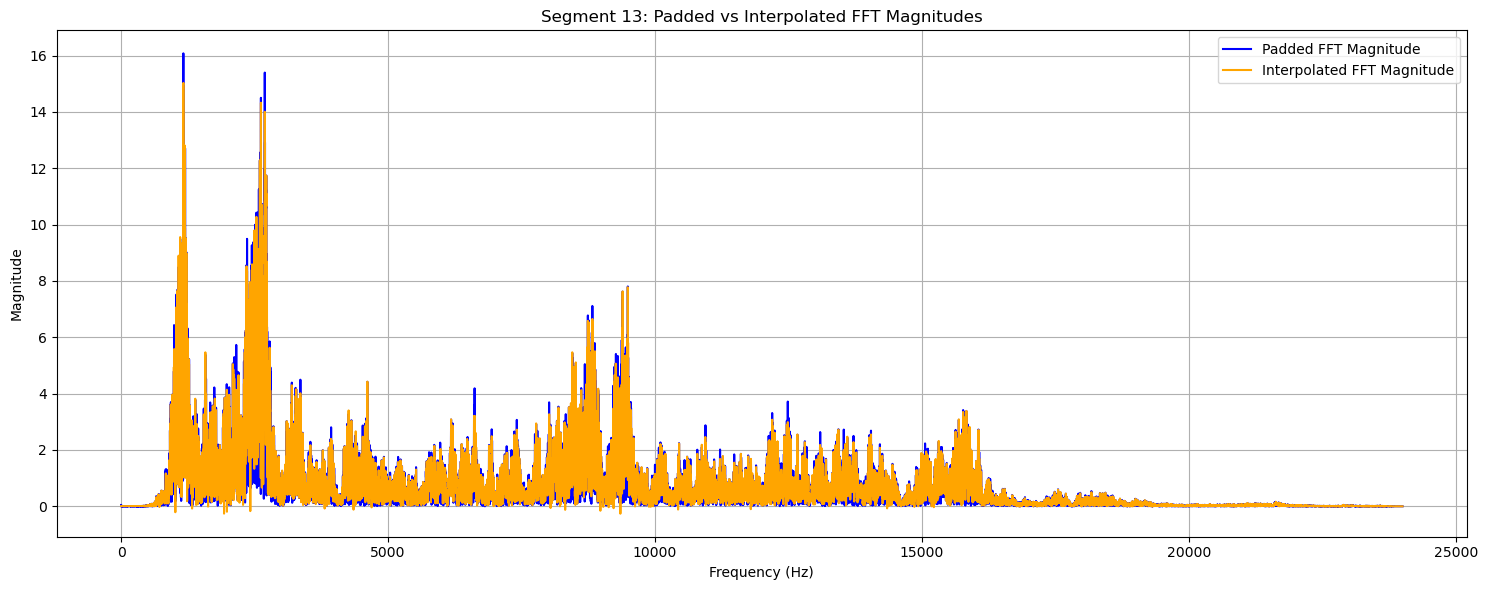

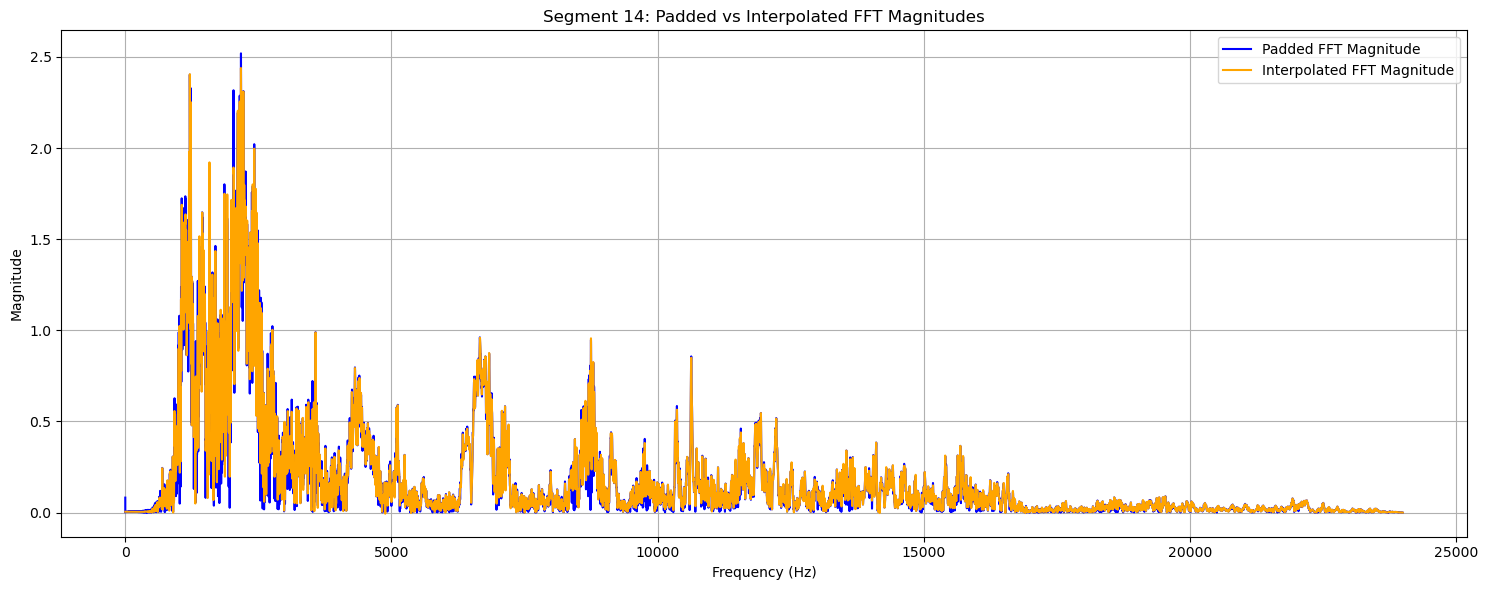

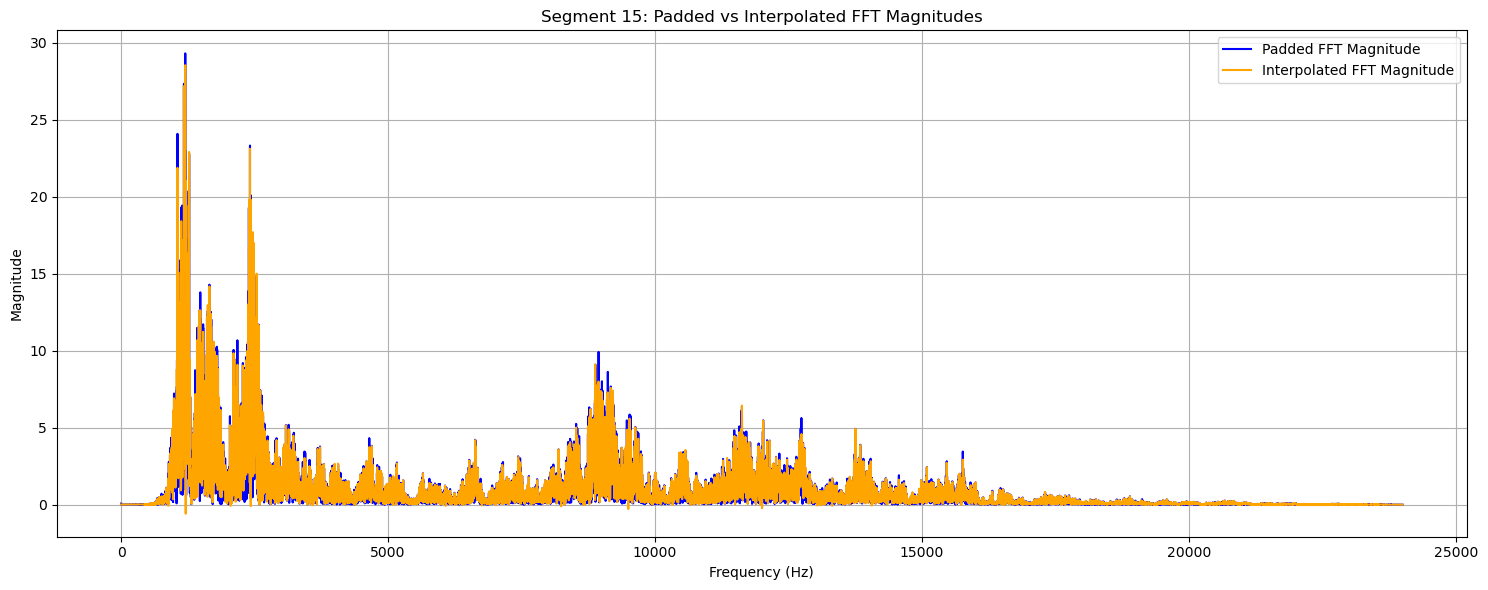

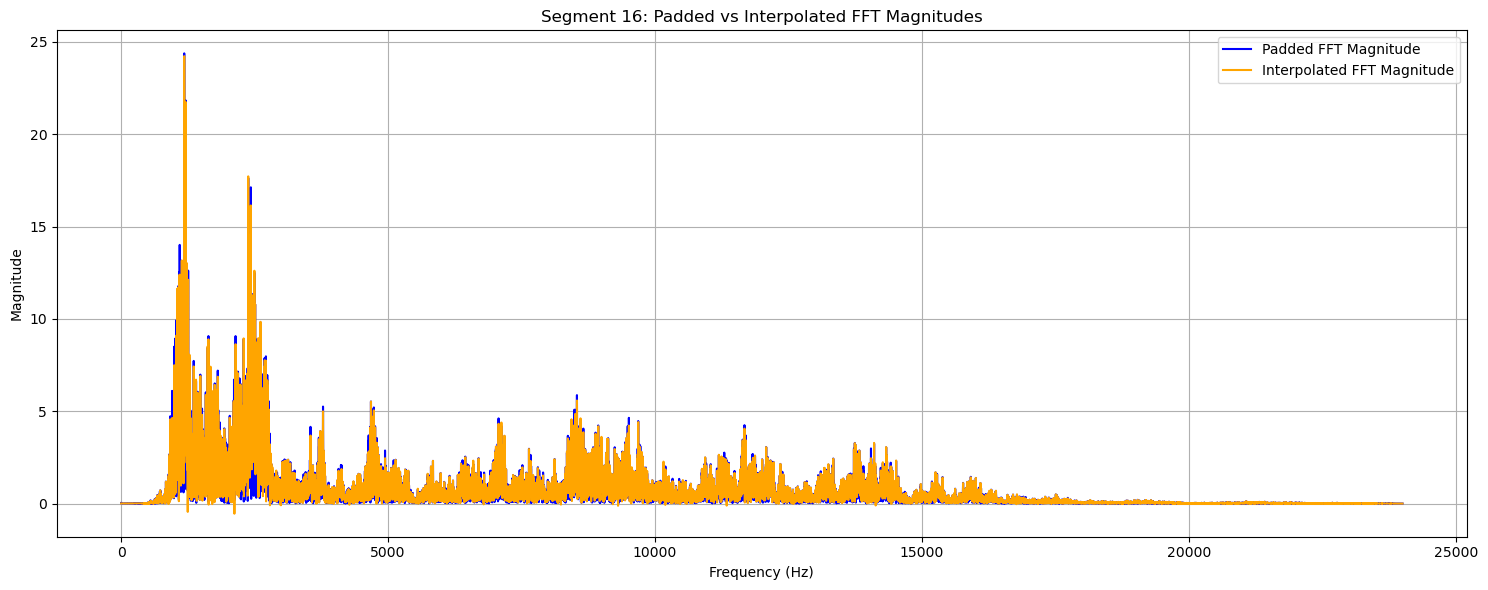

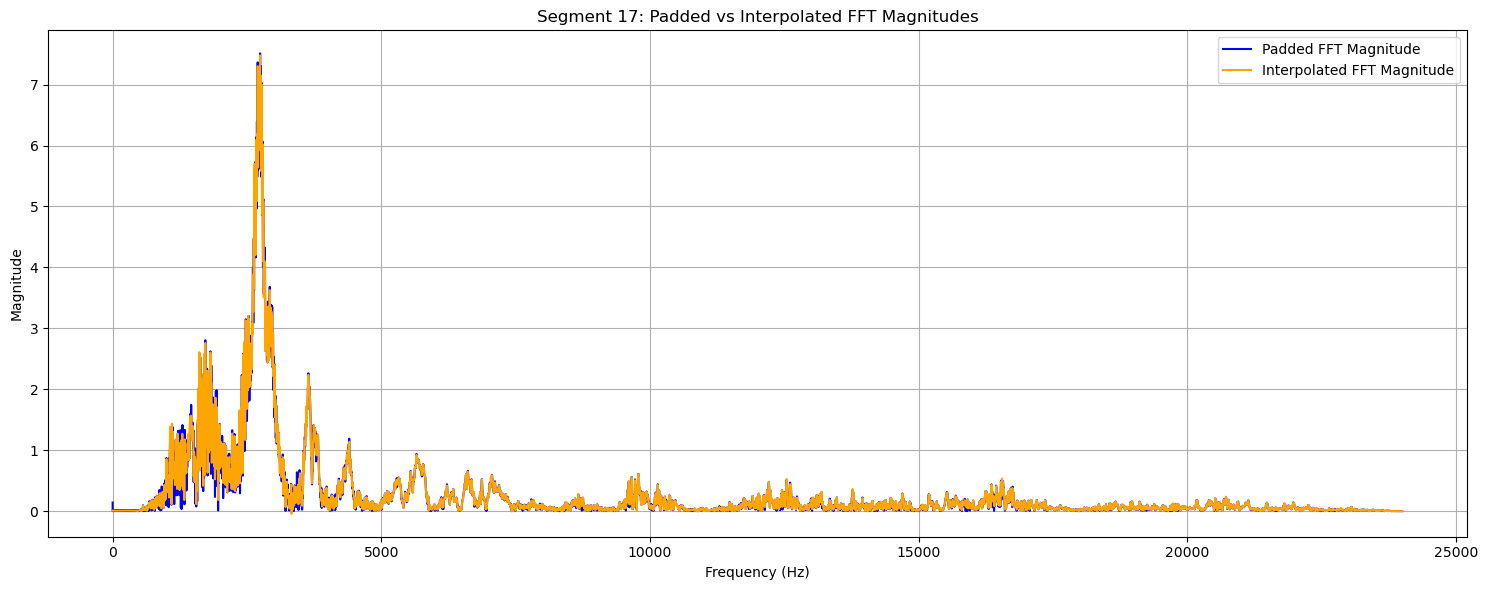

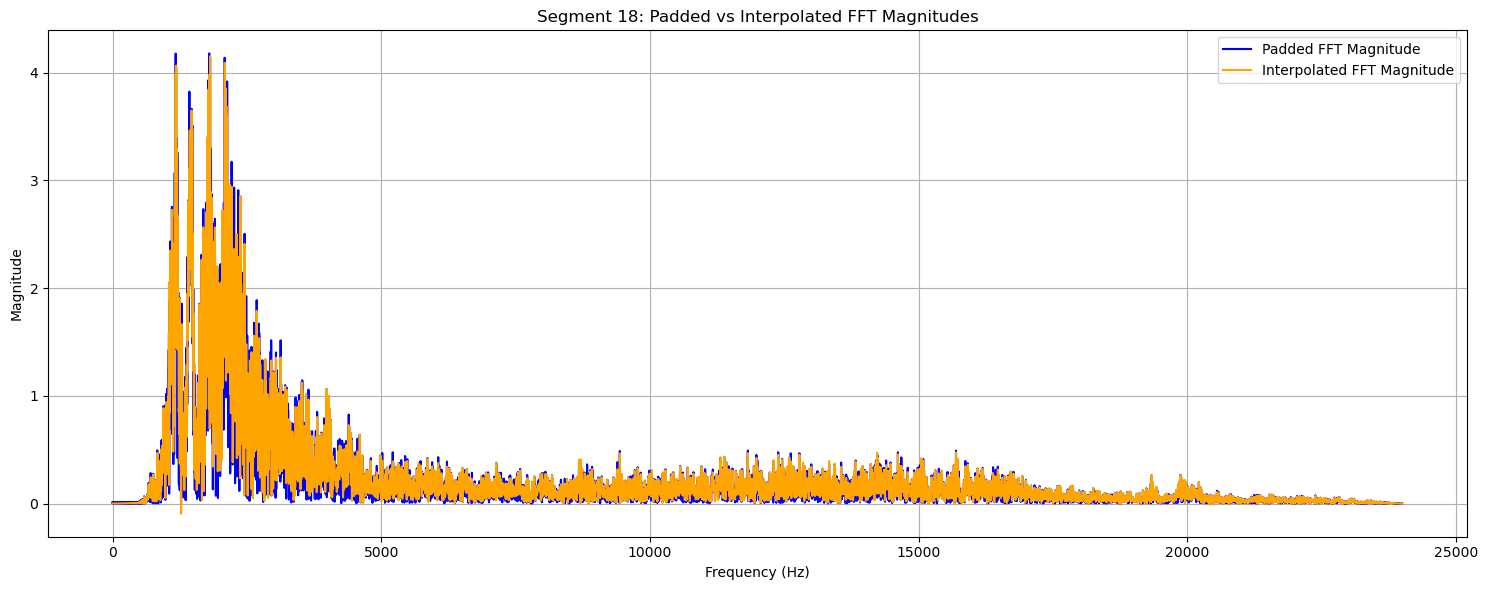

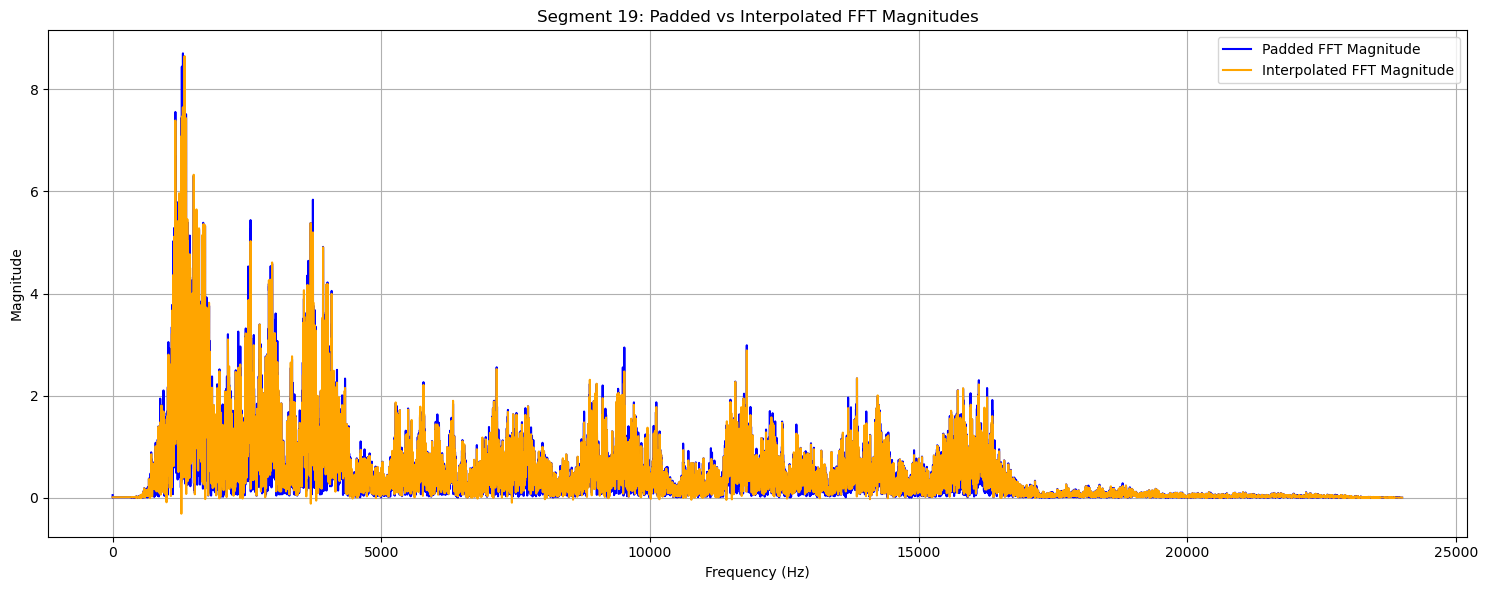

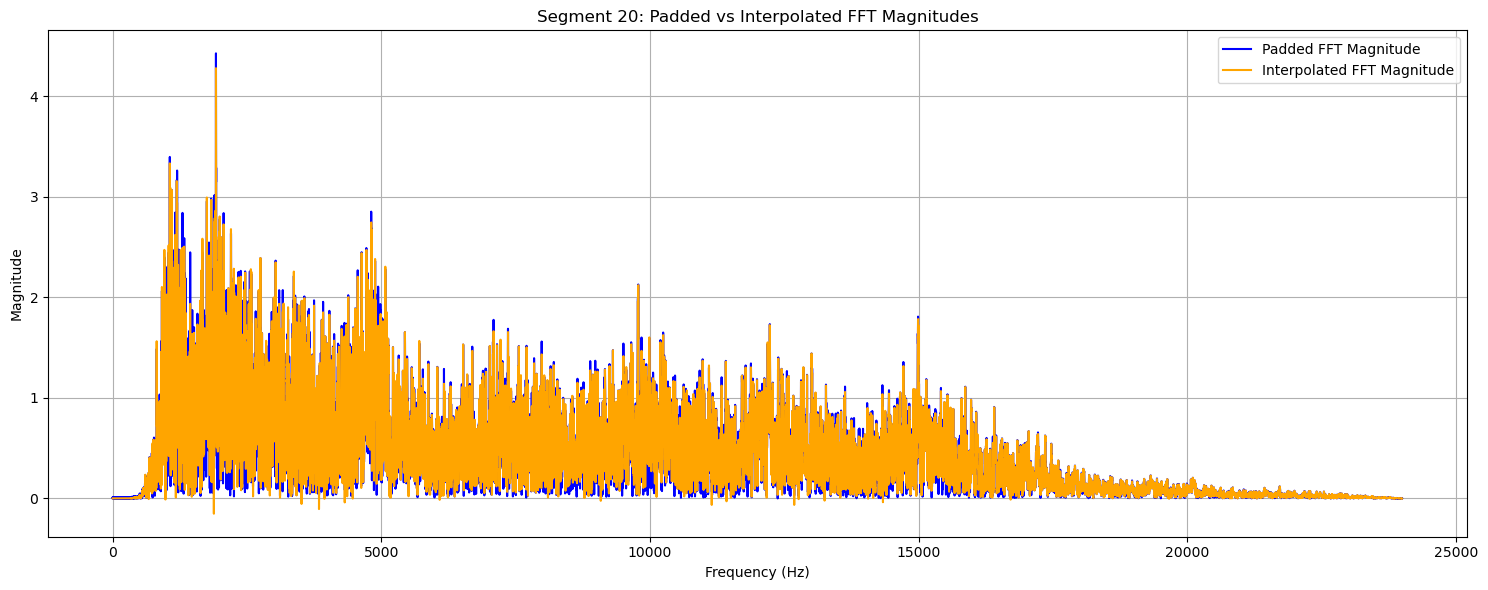

In [59]:
plot_padded_and_interpolated_for_each_segment(processed_random_segments_fft, num_segments_to_plot=20)

In [24]:
random_c0 = [1,3,7,8]
random_c1 = [4,9,12,16,18,19,22,23,24,25,26,30,34,35,36,37,39,41,42,43,45,46,47,54,56,58,62,63,68,70,73,75,77,78,83,84,85,87,89,90,93,96,100,49,2,10,32,38]
random_c2 = [11,13,14,33,40,44,50,52,55,57,59,60,71,76,80,81,82,86,92,94,97,61,5,28,29,48,65,66,72,91]
random_c3 = [17,20,27,31,51,64,69,79,98]
random_c4 = [53,67,74,88]
random_c5 = [95,6,21,99]
random_c6 = [15]

random_c0 = [i - 1 for i in random_c0]
random_c1 = [i - 1 for i in random_c1]
random_c2 = [i - 1 for i in random_c2]
random_c3 = [i - 1 for i in random_c3]
random_c4 = [i - 1 for i in random_c4]
random_c5 = [i - 1 for i in random_c5]
random_c6 = [i - 1 for i in random_c6]

cluster_to_segments = {
    0: random_c0,
    1: random_c1,
    2: random_c2,
    3: random_c3,
    4: random_c4,
    5: random_c5,
    6: random_c6,
}

100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 1/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 2/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 3/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 4/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Gro

Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 40/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 41/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 42/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 43/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 44/100...
Extracting and standardizing FFT magnitudes...


Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 81/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 82/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 83/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 84/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Gro

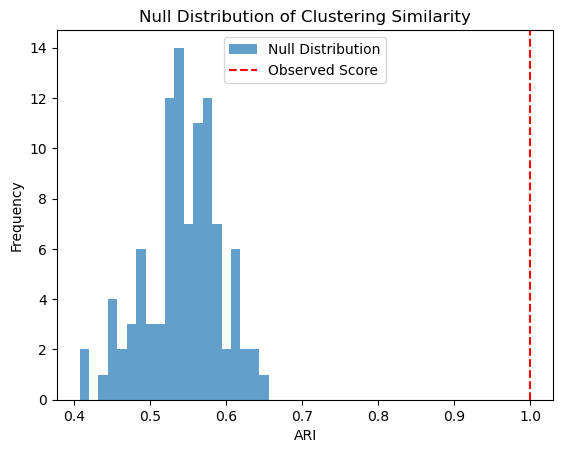

In [25]:
ground_truth_labels = np.zeros(100, dtype=int)

for cluster_id, indices in cluster_to_segments.items():
    for idx in indices:
        ground_truth_labels[idx] = cluster_id

        
print(len(processed_random_segments_fft))
num_iterations = 100
n_clusters = 7
temp = deepcopy(processed_random_segments_fft)
null_scores, observed_score = compute_null_distribution(
    temp,
    ground_truth=None,
    n_clusters=n_clusters,
    num_iterations=num_iterations
)

visualize_null_distribution(null_scores, observed_score)

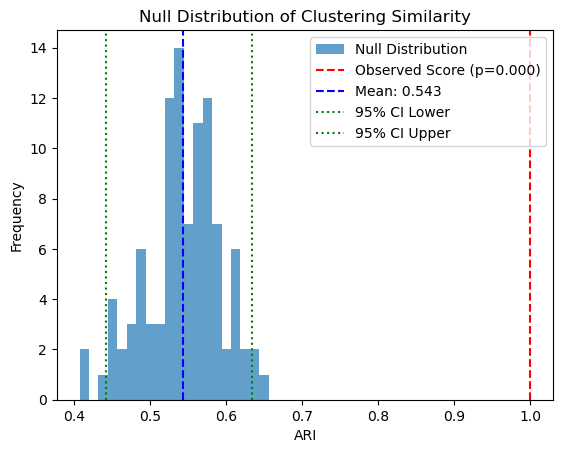

In [26]:
mean_null = np.mean(null_scores)
std_null = np.std(null_scores)
lower, upper = np.percentile(null_scores, [2.5, 97.5])
z_score = (observed_score - mean_null) / std_null
p_value = np.mean(np.array(null_scores) >= observed_score)

plt.hist(null_scores, bins=20, alpha=0.7, label='Null Distribution')
plt.axvline(observed_score, color='red', linestyle='dashed', label=f'Observed Score (p={p_value:.3f})')
plt.axvline(mean_null, color='blue', linestyle='--', label=f'Mean: {mean_null:.3f}')
plt.axvline(lower, color='green', linestyle=':', label='95% CI Lower')
plt.axvline(upper, color='green', linestyle=':', label='95% CI Upper')
plt.legend()
plt.title('Null Distribution of Clustering Similarity')
plt.xlabel('ARI')
plt.ylabel('Frequency')
plt.show()

In [27]:
def add_gaussian_noise(processed_segments, noise_level=0.01):
    noisy_segments = deepcopy(processed_segments)
    for segment in noisy_segments:
        segment['interpolated_fft_magnitude'] += np.random.normal(
            0, noise_level, size=len(segment['interpolated_fft_magnitude'])
        )
    return noisy_segments

def stability_analysis(processed_segments, n_clusters, num_perturbations=50, noise_level=0.01):
    print("Running spectral clustering on original data...")
    original_clusters = spectral_clustering_workflow(processed_segments, n_clusters=n_clusters, source='fft')
    original_labels = get_cluster_labels(original_clusters)


    ari_scores = []
    for i in range(num_perturbations):
        print(f"Perturbation {i + 1}/{num_perturbations}")
        noisy_segments = add_gaussian_noise(processed_segments, noise_level=noise_level)
        perturbed_clusters = spectral_clustering_workflow(noisy_segments, n_clusters=n_clusters, source='fft')
        perturbed_labels = get_cluster_labels(perturbed_clusters)

        ari = adjusted_rand_score(original_labels, perturbed_labels)
        ari_scores.append(ari)
    
    return ari_scores

def visualize_stability(ari_scores):
    plt.figure(figsize=(8, 6))
    plt.hist(ari_scores, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(np.mean(ari_scores), color='red', linestyle='dashed', label=f"Mean ARI: {np.mean(ari_scores):.3f}")
    plt.xlabel("ARI")
    plt.ylabel("Frequency")
    plt.title("Stability Analysis of Spectral Clustering")
    plt.legend()
    plt.show()

Running spectral clustering on original data...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 1/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 2/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 3/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 4/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visua

Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 40/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 41/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 42/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 43/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Gro

Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 80/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 81/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 82/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Perturbation 83/100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Gro

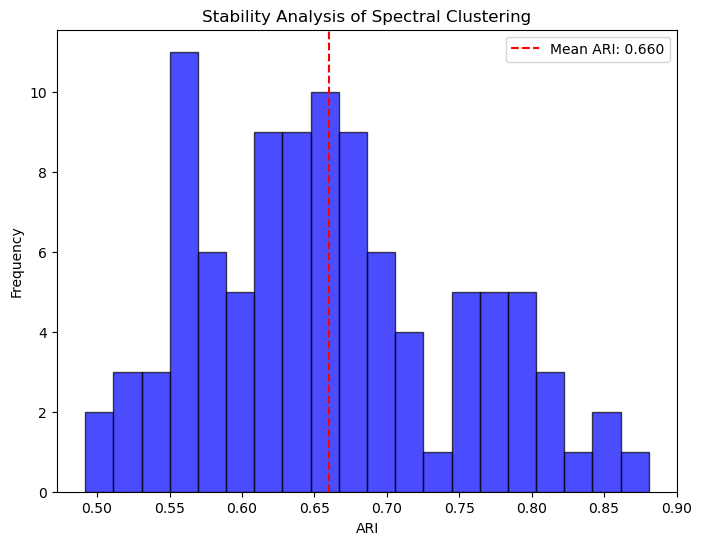

In [28]:
n_clusters = 7
num_perturbations = 100
noise_level = 0.01

temp = deepcopy(processed_random_segments_fft)
# Assuming 'processed_random_segments_fft' contains the FFT data
ari_scores = stability_analysis(temp, n_clusters, num_perturbations, noise_level)
visualize_stability(ari_scores)

In [29]:
true_labels = [0, 0, 1, 1, 2, 2]
predicted_labels = [0, 0, 1, 2, 2, 1]

ari = adjusted_rand_score(true_labels, predicted_labels)
print(ari)

0.16666666666666666


In [30]:
def plot_cluster_magnitudes(clusters):
    """
    Plot FFT magnitudes for each cluster, including individual magnitudes and average magnitude.

    Args:
        clusters (dict): A dictionary where keys are cluster IDs and values are lists of segments.
    """
    print("Plotting individual magnitudes and average magnitude for each cluster...")
    for cluster_id, cluster_segments in clusters.items():
        plt.figure(figsize=(10, 6))
        for segment in cluster_segments:
            plt.plot(segment['padded_fft_magnitude'], color='gray', alpha=0.3, linewidth=0.5)

        # Calculate and plot the average magnitude
        magnitudes = [segment['padded_fft_magnitude'] for segment in cluster_segments]
        avg_magnitude = np.mean(magnitudes, axis=0)
        plt.plot(avg_magnitude, color='red', linewidth=2, label='Average Magnitude')

        plt.title(f"Cluster {cluster_id}: FFT Magnitudes")
        plt.xlabel('Frequency Bin')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True)
        plt.show()

In [31]:
# plot_cluster_magnitudes(clusters)

In [32]:
def process_individual_snippets_with_wavelet(all_segments, file_names, wavelet='db4', sr=None, max_level=None):
    processed_segments_dwt = []
    
    file_idx = 0
    while file_idx < len(file_names):
        file_name = file_names[file_idx]
        print(f"Loading file: {file_name}")
        
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            file_idx += 1
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]

        for idx, segment in enumerate(file_segments):
            start_time = segment['start_time']
            end_time = segment['end_time']
            
            print(f"Processing snippet {idx + 1}/{len(file_segments)}: {start_time:.2f}s to {end_time:.2f}s")

            start_idx = int(start_time * original_sr)
            end_idx = int(end_time * original_sr)
            
            snippet = y[start_idx:end_idx]
            
            # Perform DWT
            coeffs = pywt.wavedec(snippet, wavelet=wavelet, level=max_level)
            power_levels = [np.square(np.abs(c)) for c in coeffs]  # Calculate power for each level
            
            processed_segments_dwt.append({
                'file_name': file_name,
                'start_time': start_time,
                'end_time': end_time,
                'wavelet_coeffs': coeffs,
                'wavelet_power_levels': power_levels,
                'frequency_bands': pywt.scale2frequency(wavelet, np.arange(1, len(coeffs) + 1)) * original_sr / 2
            })

        file_idx += 1

    return processed_segments_dwt


In [79]:
folder_path = '../audios/lab_audios/first_batch/'
file_names = [f'{folder_path}recording_20240927_204919-{i:02d}.wav' for i in range(1,17)]
# processed_segments_wavelet = process_individual_snippets_with_wavelet(all_segments, file_names, wavelet='db4')

# # Save the results if needed
# with open(f'{folder_path}processed_segments_DWT.pkl', 'wb') as file:
#     pickle.dump(processed_segments_wavelet, file)

# print("Wavelet processing complete. Results saved.")

with open(f'{folder_path}processed_segments_DWT.pkl', 'rb') as file:
    processed_segments_wavelet = pickle.load(file)

In [84]:
def interpolate_wavelet_power_levels_to_longest(processed_segments_wavelet):
    max_length = max(
        max(len(power) for power in segment['wavelet_power_levels'])
        for segment in processed_segments_wavelet
    )
    
    for segment in processed_segments_wavelet:
        power_levels = segment['wavelet_power_levels']
        
        interpolated_power_levels = []
        for power in power_levels:
            x = np.linspace(0, 1, len(power))
            interp_func = interp1d(x, power, kind='linear', fill_value='extrapolate')  # Interpolation function
            x_new = np.linspace(0, 1, max_length)
            interpolated_power = interp_func(x_new)
            interpolated_power_levels.append(interpolated_power)
        
        segment['interpolated_power_levels'] = interpolated_power_levels
    
    return processed_segments_wavelet

def pad_wavelet_power_levels_to_longest(processed_segments_wavelet):
    max_length = max(
        max(len(power) for power in segment['wavelet_power_levels'])
        for segment in processed_segments_wavelet
    )
    max_levels = max(len(segment['wavelet_power_levels']) for segment in processed_segments_wavelet)
    
    for segment in processed_segments_wavelet:
        power_levels = segment['wavelet_power_levels']
        
        # Pad each power level to `max_length`
        padded_power_levels = [
            np.pad(power, (0, max_length - len(power)), mode='constant', constant_values=0.0001) for power in power_levels
        ]
        
        # Pad the segment with additional zero arrays to match `max_levels`
        while len(padded_power_levels) < max_levels:
            padded_power_levels.append(np.zeros(max_length))
        
        segment['padded_power_levels'] = padded_power_levels
    
    return processed_segments_wavelet


In [35]:
# processed_segments_wavelet = interpolate_wavelet_power_levels_to_longest(processed_segments_wavelet)

In [77]:
def plot_dwt_powers_raw(processed_segments_wavelet, num_signals=10):
    plt.figure(figsize=(15, 10))

    for i, segment in enumerate(processed_segments_wavelet[:num_signals], start=1):
        power_levels = segment['padded_power_levels']
        frequency_bands = segment['frequency_bands']  # Approximate frequency bands
        
        # Stack the padded power levels into a 2D array
        raw_power = np.vstack(power_levels)

        plt.subplot(2, 5, i)  # Arrange in a 2x5 grid
        plt.imshow(
            raw_power,
            aspect='auto',
            origin='lower',
            extent=[0, raw_power.shape[1], frequency_bands[0], frequency_bands[-1]],
            cmap='viridis',
            vmin=0,
            vmax=0.0001
        )
        plt.title(f"Segment {i}")
        plt.xlabel("Time Frames")
        plt.ylabel("Frequency Bands (Hz)")
        plt.colorbar(label="Power")

    plt.tight_layout()
    plt.show()

In [85]:
# processed_random_segments_wavelet = process_individual_snippets_with_wavelet(random_segments[:100], file_names, wavelet='db4')

# # Save the results if needed
# with open(f'{folder_path}processed_random_segments_DWT.pkl', 'wb') as file:
#     pickle.dump(processed_random_segments_wavelet, file)
    
with open(f'{folder_path}processed_random_segments_DWT.pkl', 'rb') as file:
    processed_random_segments_wavelet = pickle.load(file)

In [86]:
processed_random_segments_wavelet = interpolate_wavelet_power_levels_to_longest(processed_random_segments_wavelet)
processed_random_segments_wavelet = pad_wavelet_power_levels_to_longest(processed_random_segments_wavelet)

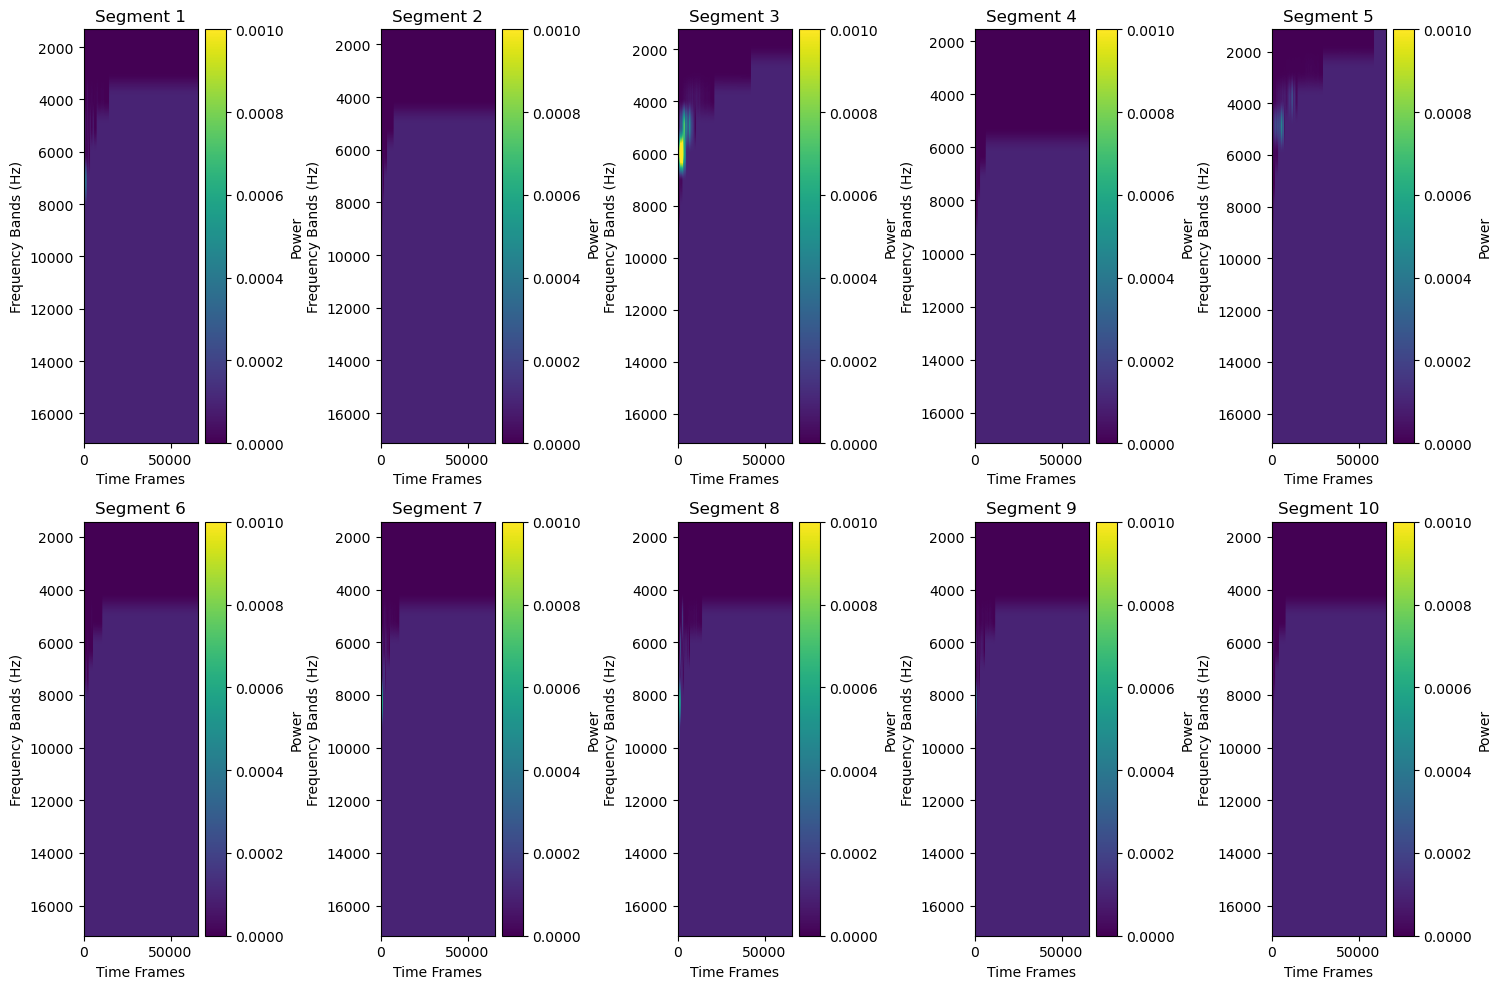

In [87]:
# wavelet just somehow refuses to work
plot_dwt_powers_raw(processed_random_segments_wavelet, num_signals=10)

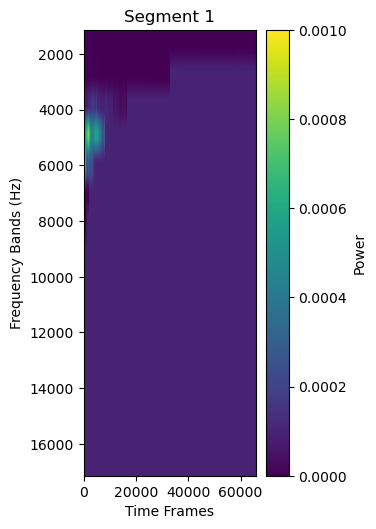

In [91]:
def find_longest_wavelet_segment(processed_segments_wavelet):
    # Initialize variables to track the longest segment and its length
    longest_segment = None
    max_length = 0

    # Iterate through all segments
    for segment in processed_segments_wavelet:
        # Find the maximum length of wavelet power levels in this segment
        segment_max_length = max(len(power) for power in segment['wavelet_power_levels'])
        
        # Update if this segment has the longest power level so far
        if segment_max_length > max_length:
            max_length = segment_max_length
            longest_segment = segment

    return longest_segment, max_length

longest_segment, max_length = find_longest_wavelet_segment(processed_random_segments_wavelet)

lsl = [longest_segment]

plot_dwt_powers_raw(lsl, num_signals=1)

Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 1/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 2/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 3/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 4/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 5/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 6/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 7/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 8/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 9/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 10/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 11/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 12/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 13/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 14/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 15/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 16/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 17/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 18/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 19/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 20/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 21/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 22/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 23/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 24/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 25/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 26/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 27/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 28/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 29/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 30/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 31/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 32/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 33/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 34/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 35/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 36/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 37/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 38/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 39/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 40/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 41/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 42/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 43/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 44/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 45/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 46/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 47/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 48/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 49/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 50/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 51/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 52/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 53/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 54/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 55/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 56/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 57/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 58/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 59/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 60/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 61/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 62/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 63/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 64/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 65/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 66/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 67/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 68/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 69/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 70/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 71/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 72/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 73/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 74/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 75/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 76/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 77/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 78/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 79/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 80/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 81/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 82/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 83/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 84/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 85/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 86/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 87/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 88/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 89/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 90/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 91/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 92/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 93/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 94/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 95/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 96/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 97/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 98/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 99/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 100/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...


/Users/dpr12/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...


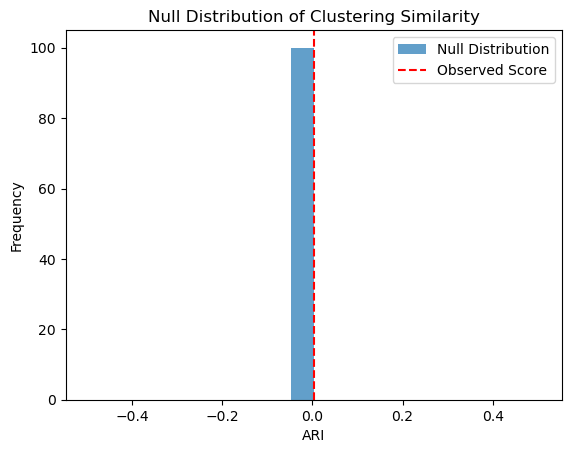

In [90]:
num_iterations = 100
n_clusters = 7
null_scores, observed_score = compute_null_distribution(
    processed_random_segments_wavelet,
    ground_truth=ground_truth_labels,
    n_clusters=n_clusters,
    num_iterations=num_iterations,
    source='DWT'
)

visualize_null_distribution(null_scores, observed_score)

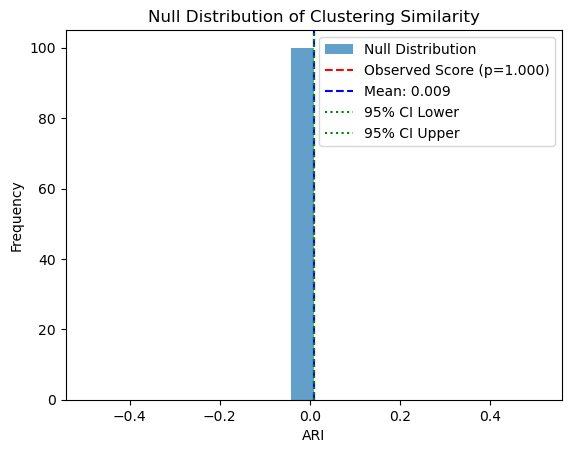

In [41]:
mean_null = np.mean(null_scores)
std_null = np.std(null_scores)
lower, upper = np.percentile(null_scores, [2.5, 97.5])
z_score = (observed_score - mean_null) / std_null
p_value = np.mean(np.array(null_scores) >= observed_score)

plt.hist(null_scores, bins=20, alpha=0.7, label='Null Distribution')
plt.axvline(observed_score, color='red', linestyle='dashed', label=f'Observed Score (p={p_value:.3f})')
plt.axvline(mean_null, color='blue', linestyle='--', label=f'Mean: {mean_null:.3f}')
plt.axvline(lower, color='green', linestyle=':', label='95% CI Lower')
plt.axvline(upper, color='green', linestyle=':', label='95% CI Upper')
plt.legend()
plt.title('Null Distribution of Clustering Similarity')
plt.xlabel('ARI')
plt.ylabel('Frequency')
plt.show()